Author: Bryce Drynan

Date 2/26/24

# Loan Defaulting

# Package Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
##########################

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

############################

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score, average_precision_score
from sklearn.inspection import PartialDependenceDisplay

##########################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier


# Load Data

In [2]:
path = "C:\VS_code\Data\loan_train.csv"

df = pd.read_csv(path)

df.head().T

,0,1,2,3,4
id,1077501.0,1077430.0,1076863.0,1069639.0,1072053.0
member_id,1296599.0,1314167.0,1277178.0,1304742.0,1288686.0
loan_amnt,5000.0,2500.0,10000.0,7000.0,3000.0
funded_amnt,5000.0,2500.0,10000.0,7000.0,3000.0
funded_amnt_inv,4975.0,2500.0,10000.0,7000.0,3000.0
term,36 months,60 months,36 months,60 months,36 months
int_rate,10.65%,15.27%,13.49%,15.96%,18.64%
installment,162.87,59.83,339.31,170.08,109.43
grade,B,C,C,C,E
sub_grade,B2,C4,C1,C5,E1


# Visual Exploration of the Data

In [3]:
def df_profile(df, target):

    df = df.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]

    pd.options.display.float_format = '{:.5f}'.format

    categorical_features = [ c for c in df.select_dtypes(include = object).columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count',
                     'nunique',
                     #'mean',
                     #'min',
                     #'max'
                     ]).transpose().reset_index().rename(columns={"index": "feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt


    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"

    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

profile = df_profile(df, 'loan_status')
profile

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,id,float64,29774,29774,3,29774,0.00010,0.99990,NUMERIC,"EXCLUDE, GT 90% UNIQUE"
1,fico_range_low,float64,29774,43,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
2,fico_range_high,float64,29774,43,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
3,inq_last_6mths,float64,29754,27,23,29754,0.00077,0.00091,NUMERIC,NO WARNING
4,mths_since_last_delinq,float64,10870,90,18907,10870,0.63495,0.00302,NUMERIC,"EXCLUDE, GT 50% MISSING"
5,mths_since_last_record,float64,2569,107,27208,2569,0.91373,0.00359,NUMERIC,"EXCLUDE, GT 50% MISSING"
6,open_acc,float64,29754,44,23,29754,0.00077,0.00148,NUMERIC,NO WARNING
7,pub_rec,float64,29754,6,23,29754,0.00077,0.00020,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
8,revol_bal,float64,29774,18399,3,29774,0.00010,0.61789,NUMERIC,NO WARNING
9,pub_rec_bankruptcies,float64,28811,3,966,28811,0.03244,0.00010,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"


## Pull out variables that could need type adjustment for evaluation

In [4]:
type_change_candidates = profile[profile['feature_warning'] == 'LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY']
type_change_candidates

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
7,pub_rec,float64,29754,6,23,29754,0.00077,0.00020,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
9,pub_rec_bankruptcies,float64,28811,3,966,28811,0.03244,0.00010,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
14,collections_12_mths_ex_med,float64,29673,1,104,29673,0.00349,0.00003,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
15,policy_code,float64,29774,1,3,29774,0.00010,0.00003,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
16,acc_now_delinq,float64,29754,2,23,29754,0.00077,0.00007,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
17,chargeoff_within_12_mths,float64,29673,1,104,29673,0.00349,0.00003,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
18,delinq_amnt,float64,29754,3,23,29754,0.00077,0.00010,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
21,delinq_2yrs,float64,29754,11,23,29754,0.00077,0.00037,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
22,tax_liens,float64,29698,2,79,29698,0.00265,0.00007,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"


In the above table we can see that some of these columns only have one value which is not good for predictability as an categorical or numerical column so we will drop them. Next we will convert the other columns to class variables.

In [5]:
for col in type_change_candidates['feature_name'].to_list():
    print(df[col].value_counts())

pub_rec
0.00000    28086
1.00000     1610
2.00000       45
3.00000       11
4.00000        1
5.00000        1
Name: count, dtype: int64
pub_rec_bankruptcies
0.00000    27511
1.00000     1294
2.00000        6
Name: count, dtype: int64
collections_12_mths_ex_med
0.00000    29673
Name: count, dtype: int64
policy_code
1.00000    29774
Name: count, dtype: int64
acc_now_delinq
0.00000    29750
1.00000        4
Name: count, dtype: int64
chargeoff_within_12_mths
0.00000    29673
Name: count, dtype: int64
delinq_amnt
0.00000       29752
27.00000          1
6053.00000        1
Name: count, dtype: int64
delinq_2yrs
0.00000     26412
1.00000      2536
2.00000       531
3.00000       175
4.00000        60
5.00000        18
6.00000        11
7.00000         5
8.00000         3
11.00000        2
13.00000        1
Name: count, dtype: int64
tax_liens
0.00000    29697
1.00000        1
Name: count, dtype: int64


The only column that signals as a categorical is the acc_now_delinq column so we will convert it for now.

In [6]:
type_change_list = ['acc_now_delinq']
for col in type_change_list:
    df[col] = df[col].mask(lambda x: x.notna(), df[col].astype(str))

I noticed an import error with the revol_util and int_rate columns, it should be numeric. We will be converting it to a float on a percentage scale.

Additionally the term column and emp_length will be converted to numeric as well.

In [7]:
df['revol_util'] = df['revol_util'].str.strip('%')
df['int_rate'] = df['int_rate'].str.strip('%')
df['revol_util'] = df['revol_util'].astype('float')/100
df['int_rate'] = df['int_rate'].astype('float')/100
df['term'] = pd.to_numeric(df['term'].str.replace(' months',''))
emp_rem = [' year', 's','+', '< ']
for string in emp_rem:
    df['emp_length'] = df['emp_length'].str.replace(string ,'')
df['emp_length']=df['emp_length'].astype('float')

There are high cardinality categorical columns that we can convert to numerical to more effectivly process. Namely the date columns we are converting to months since the date of interest creating a scale. This scale functions continuoisly since the variable is time and we do not loose the integrity of its value to the model as well. They will range from -1 being the current month up to however high they need to go

In [8]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])

max_earliest = max(df['earliest_cr_line'])
max_issue = max(df['issue_d'])
max_credit = max(df['last_credit_pull_d'])
max_pymnt = max(df['last_pymnt_d'])

today = pd.to_datetime('today')

df['earliest_cr_line'] = 12*(max_earliest.year - df.earliest_cr_line.dt.year) + (max_earliest.month - df.earliest_cr_line.dt.month) - 1
df['issue_d'] = 12 * (max_issue.year - df.issue_d.dt.year) + (max_issue.month - df.issue_d.dt.month) - 1
df['last_credit_pull_d'] = 12* (max_credit.year - df.last_credit_pull_d.dt.year) + (max_issue.month - df.last_credit_pull_d.dt.month) - 1
df['last_pymnt_d'] = 12 * (max_pymnt.year - df.last_pymnt_d.dt.year) + (max_pymnt.month - df.last_pymnt_d.dt.month) - 1

Now we re-evaluate the dataframe with our transformed data

In [9]:
new_profile = df_profile(df, 'loan_status')
new_profile

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,id,float64,29774,29774,3,29774,0.00010,0.99990,NUMERIC,"EXCLUDE, GT 90% UNIQUE"
1,earliest_cr_line,float64,29754,516,23,29754,0.00077,0.01733,NUMERIC,NO WARNING
2,fico_range_low,float64,29774,43,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
3,fico_range_high,float64,29774,43,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
4,inq_last_6mths,float64,29754,27,23,29754,0.00077,0.00091,NUMERIC,NO WARNING
5,mths_since_last_delinq,float64,10870,90,18907,10870,0.63495,0.00302,NUMERIC,"EXCLUDE, GT 50% MISSING"
6,mths_since_last_record,float64,2569,107,27208,2569,0.91373,0.00359,NUMERIC,"EXCLUDE, GT 50% MISSING"
7,open_acc,float64,29754,44,23,29754,0.00077,0.00148,NUMERIC,NO WARNING
8,pub_rec,float64,29754,6,23,29754,0.00077,0.00020,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
9,revol_bal,float64,29774,18399,3,29774,0.00010,0.61789,NUMERIC,NO WARNING


Now that I have handled immediatly concerning issues regrarding the data I will seperate the columns into numeric and categorical column lists

In [10]:
cat_cols = new_profile[(new_profile['feature_warning'] == 'NO WARNING') & (new_profile['feature_type'] == 'CATEGORY') & (new_profile['nunique'] > 1)
                       & (new_profile['nunique_pct']<=.5)]
num_cols = new_profile[((new_profile['feature_warning'] == 'NO WARNING') | (new_profile['feature_warning'] == 'LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY')) 
                       & (new_profile['feature_type'] == 'NUMERIC') & (new_profile['nunique'] > 1)]

In [11]:
num_cols

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
1,earliest_cr_line,float64,29754,516,23,29754,0.00077,0.01733,NUMERIC,NO WARNING
2,fico_range_low,float64,29774,43,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
3,fico_range_high,float64,29774,43,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
4,inq_last_6mths,float64,29754,27,23,29754,0.00077,0.00091,NUMERIC,NO WARNING
7,open_acc,float64,29754,44,23,29754,0.00077,0.00148,NUMERIC,NO WARNING
8,pub_rec,float64,29754,6,23,29754,0.00077,0.00020,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
9,revol_bal,float64,29774,18399,3,29774,0.00010,0.61789,NUMERIC,NO WARNING
10,revol_util,float64,29710,1094,67,29710,0.00225,0.03674,NUMERIC,NO WARNING
11,total_acc,float64,29754,78,23,29754,0.00077,0.00262,NUMERIC,NO WARNING
12,out_prncp,float64,29774,383,3,29774,0.00010,0.01286,NUMERIC,NO WARNING


In [12]:
cat_cols

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
36,acc_now_delinq,object,29754,2,23,29754,0.00077,0.00007,CATEGORY,NO WARNING
39,zip_code,object,29774,819,3,29774,0.00010,0.02750,CATEGORY,NO WARNING
40,addr_state,object,29774,50,3,29774,0.00010,0.00168,CATEGORY,NO WARNING
42,home_ownership,object,29774,5,3,29774,0.00010,0.00017,CATEGORY,NO WARNING
43,verification_status,object,29774,3,3,29774,0.00010,0.00010,CATEGORY,NO WARNING
45,pymnt_plan,object,29774,2,3,29774,0.00010,0.00007,CATEGORY,NO WARNING
48,purpose,object,29774,14,3,29774,0.00010,0.00047,CATEGORY,NO WARNING
50,grade,object,29774,7,3,29774,0.00010,0.00024,CATEGORY,NO WARNING
51,sub_grade,object,29774,35,3,29774,0.00010,0.00118,CATEGORY,NO WARNING


# EDA

## Target breakdown

In [13]:
df['loan_status'].value_counts(normalize = True)

loan_status
current   0.84965
default   0.15035
Name: proportion, dtype: float64

## Categorical Analysis

### Histograms to assess columns

In [14]:
def hist_cat(list_of_col):
  for col in list_of_col:
    df[col].value_counts().plot(kind = 'barh')
    plt.title(f'histogram for {col}')
    if len(df[col].unique()) >= 30:
            plt.yticks([])
    print(df[col].value_counts())
    plt.show()

acc_now_delinq
0.0    29750
1.0        4
Name: count, dtype: int64


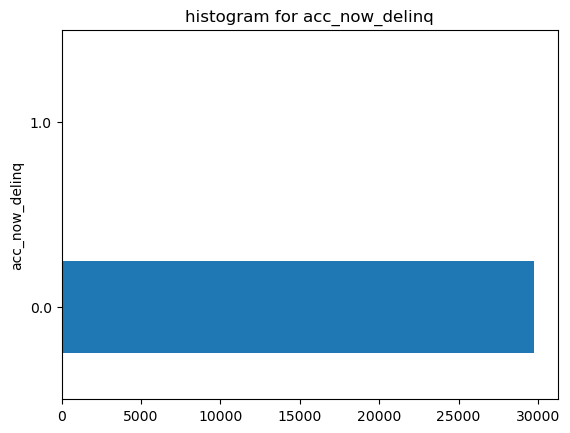

zip_code
100xx    458
945xx    407
606xx    400
112xx    384
070xx    357
        ... 
736xx      1
542xx      1
831xx      1
022xx      1
036xx      1
Name: count, Length: 819, dtype: int64


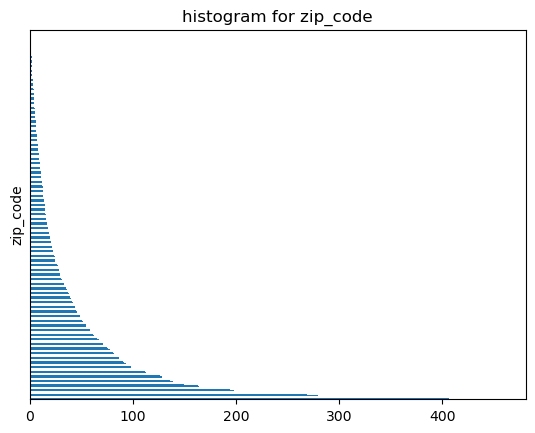

addr_state
CA    5188
NY    2836
FL    2200
TX    2067
NJ    1408
IL    1174
PA    1128
GA    1058
VA    1056
MA    1012
OH     912
MD     773
AZ     667
WA     617
NC     603
CT     575
CO     564
MI     551
MO     549
MN     449
NV     375
WI     361
SC     350
AL     339
OR     332
LA     312
KY     265
KS     212
OK     208
AR     192
UT     185
DC     164
NM     140
RI     133
WV     131
NH     128
HI     121
DE      95
WY      61
MT      60
AK      57
SD      48
VT      43
MS      19
IN      15
TN      14
IA      10
NE       9
ID       6
ME       2
Name: count, dtype: int64


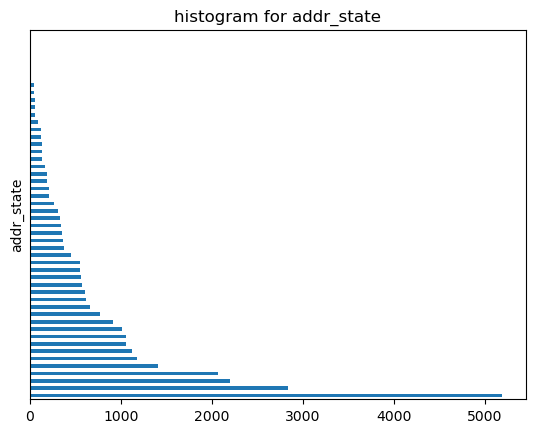

home_ownership
RENT        14064
MORTGAGE    13340
OWN          2275
OTHER          91
NONE            4
Name: count, dtype: int64


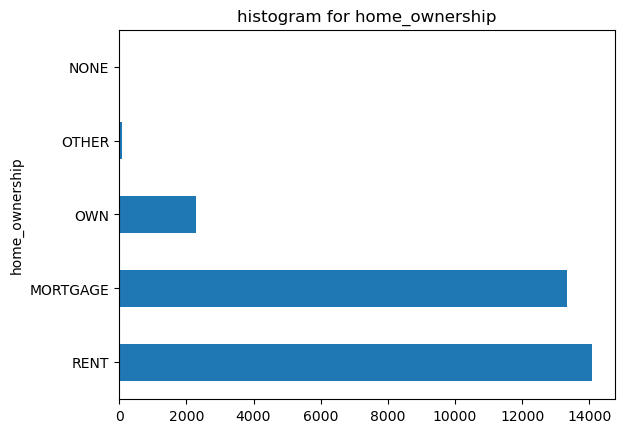

verification_status
Not Verified       13128
Verified            9460
Source Verified     7186
Name: count, dtype: int64


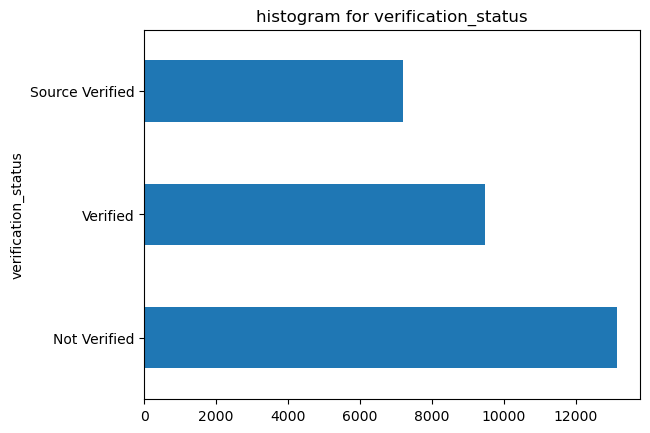

pymnt_plan
n    29773
y        1
Name: count, dtype: int64


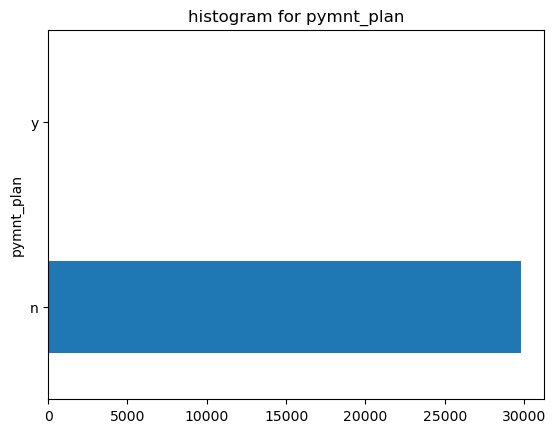

purpose
debt_consolidation    13816
credit_card            3850
other                  3108
home_improvement       2226
major_purchase         1643
small_business         1387
car                    1118
wedding                 704
medical                 528
moving                  448
house                   313
educational             279
vacation                277
renewable_energy         77
Name: count, dtype: int64


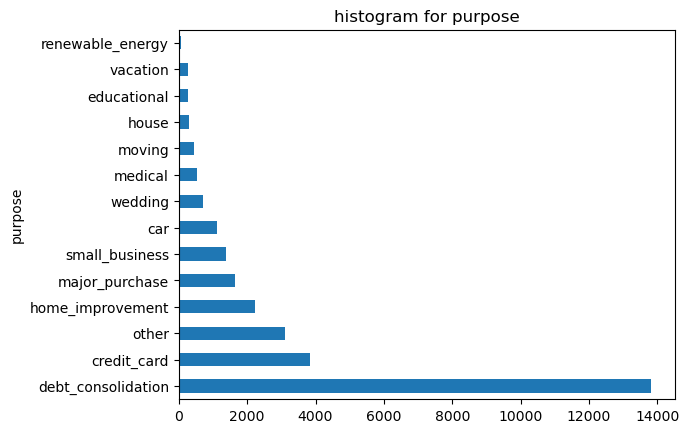

grade
B    8620
A    7142
C    6068
D    4268
E    2391
F     909
G     376
Name: count, dtype: int64


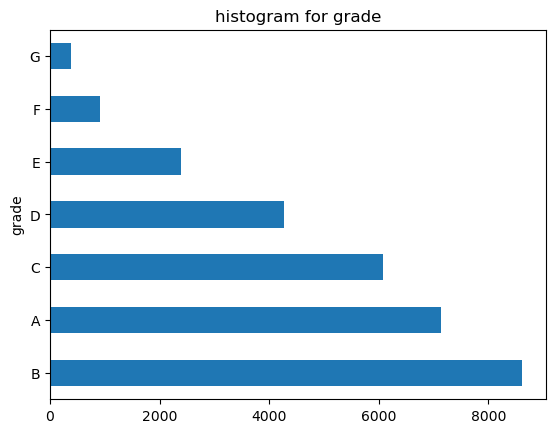

sub_grade
B3    2088
A4    2044
A5    1957
B5    1932
B4    1774
C1    1601
B2    1486
C2    1461
B1    1340
A3    1244
C3    1178
A2    1109
D2    1072
C4     940
D3     922
C5     888
D4     806
A1     788
D1     748
D5     720
E1     609
E2     560
E3     475
E4     391
E5     356
F1     274
F2     210
F3     176
F4     147
F5     102
G1     102
G4      76
G2      75
G5      63
G3      60
Name: count, dtype: int64


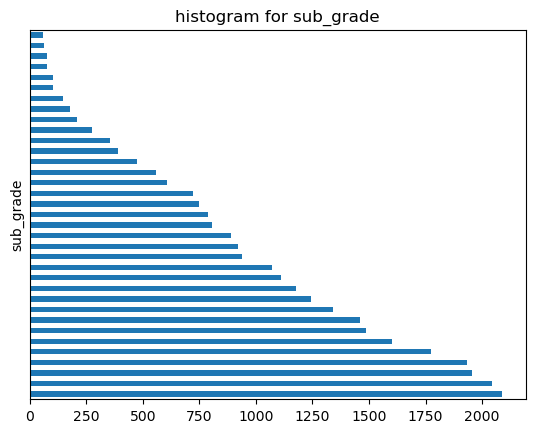

In [15]:
hist_cat(cat_cols['feature_name'].to_list())

After assessing the histgrams I want to remove columns that are extremely imbalanced in terms of class size.

In [16]:
cat_cols = cat_cols['feature_name'].to_list()
cat_cols.remove('zip_code')
cat_cols.remove('pymnt_plan')
cat_cols.remove('acc_now_delinq')

### % default by column and type

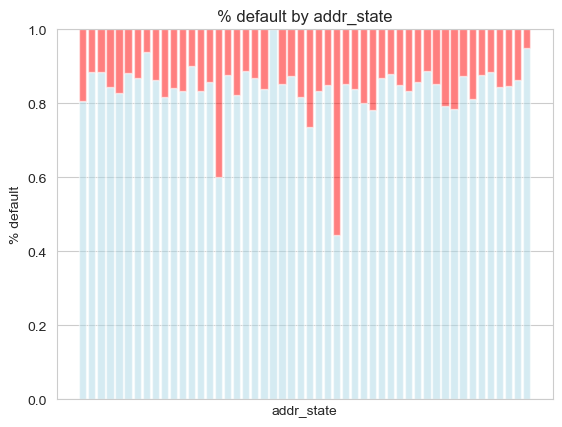

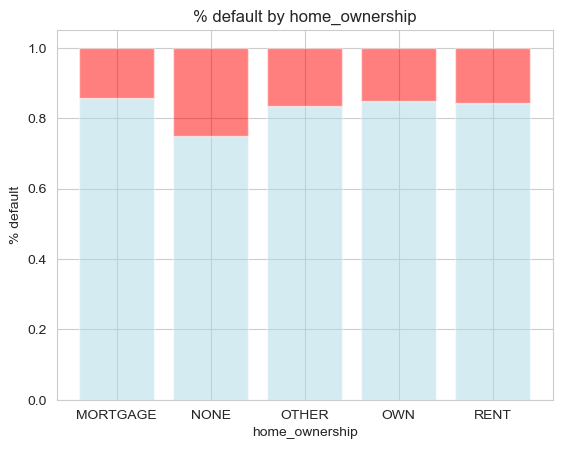

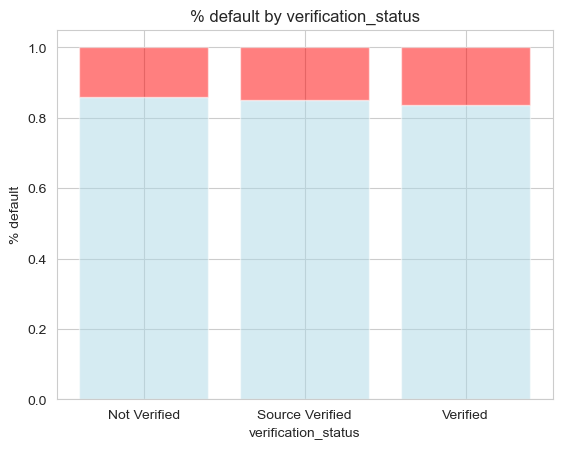

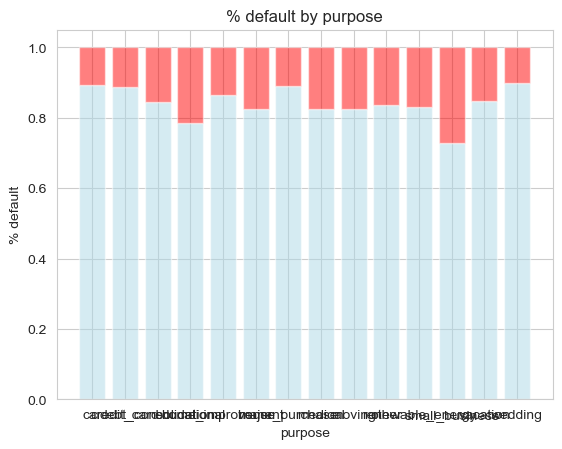

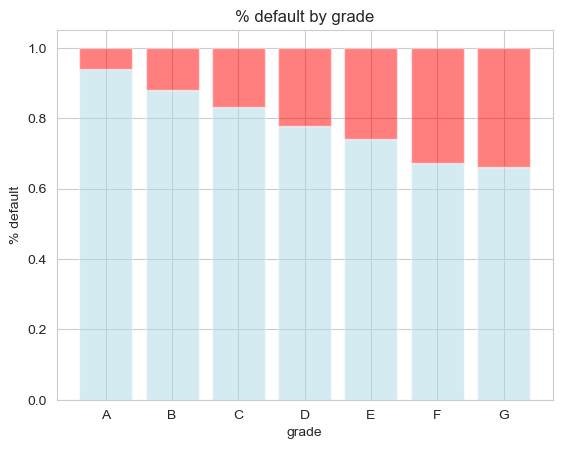

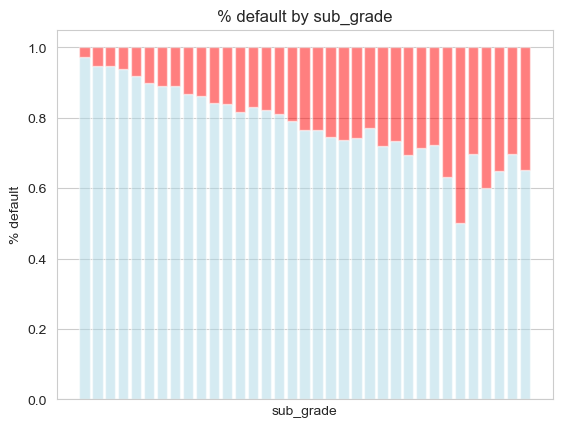

In [63]:
def target_perc(cat_col, target):
    for col in cat_col:
        ctab = pd.crosstab(df[col], df[target], normalize ='index').reset_index()
        plt.bar(ctab[col].astype('str'), ctab['current'], facecolor = 'lightblue', alpha = .5)
        plt.bar(ctab[col].astype('str'), ctab['default'], bottom = ctab['current'],facecolor = 'red', alpha = .5)
        plt.title(f'% default by {col}')
        plt.xlabel(f'{col}')
        plt.ylabel("% default")
        if len(df[col].unique()) >= 30:
            plt.xticks([])
        plt.show()
        
target_perc(cat_cols, 'loan_status')

A few columns have the same default rate across classes, but we will keep them to see if there is any underlying pattern in the data we cannot immediatly see.

## Numerical Analysis

In [18]:
df[num_cols['feature_name'].to_list()].agg(['min','median', 'mean', 'max']).T

,min,median,mean,max
earliest_cr_line,-1.00000,125.00000,140.22931,753.00000
fico_range_low,610.00000,710.00000,713.05317,825.00000
fico_range_high,614.00000,714.00000,717.05317,829.00000
inq_last_6mths,0.00000,1.00000,1.08409,33.00000
open_acc,1.00000,9.00000,9.33901,47.00000
pub_rec,0.00000,0.00000,0.05855,5.00000
revol_bal,0.00000,8783.50000,14310.00064,1207359.00000
revol_util,0.00000,0.49500,0.49085,1.19000
total_acc,1.00000,20.00000,22.08278,81.00000
out_prncp,0.00000,0.00000,11.79629,3126.61000


### Boxplots

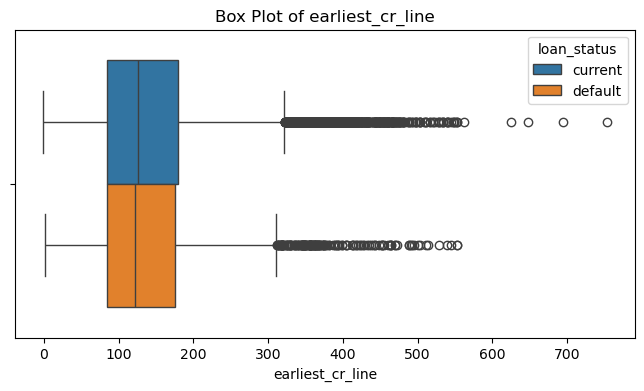

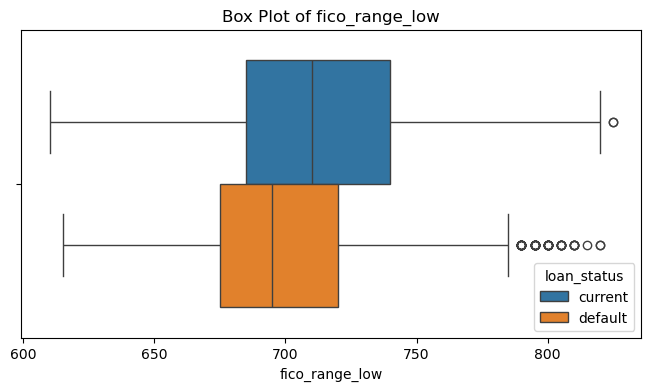

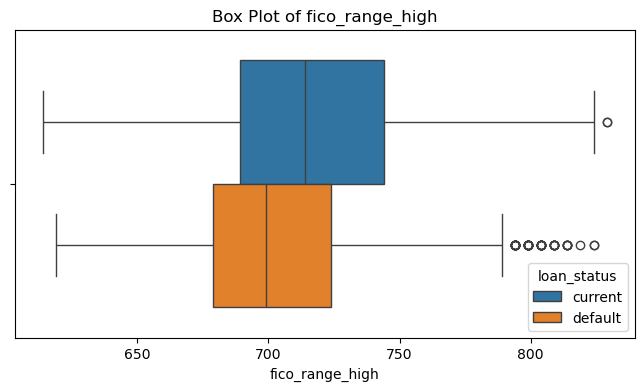

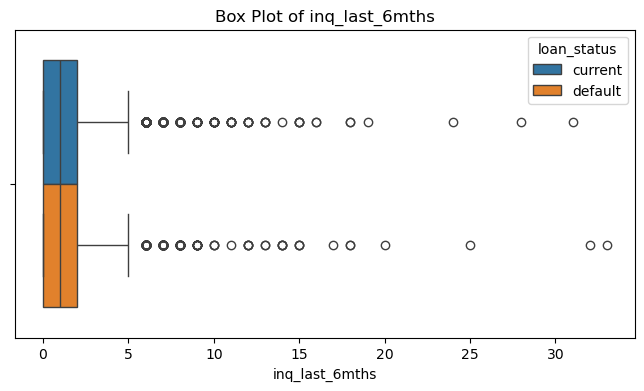

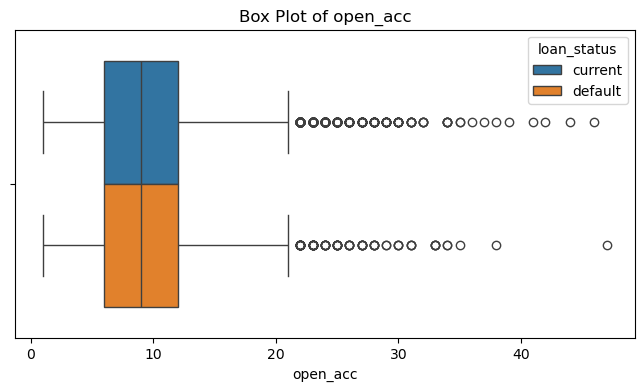

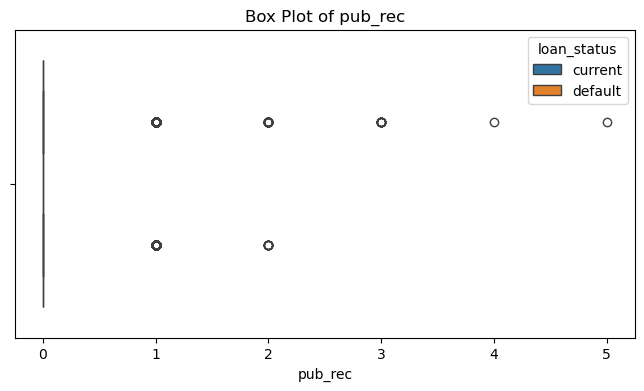

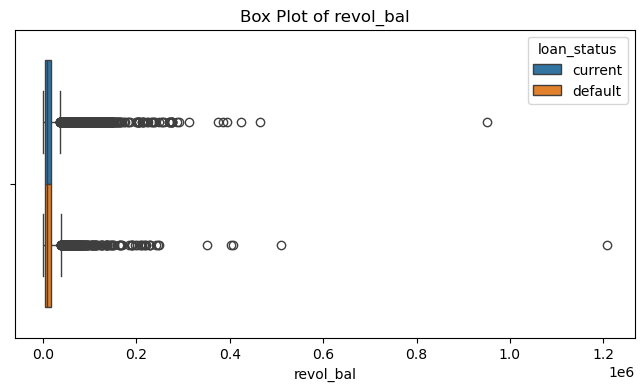

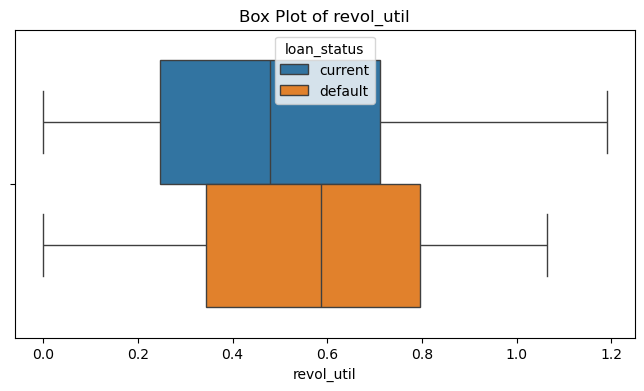

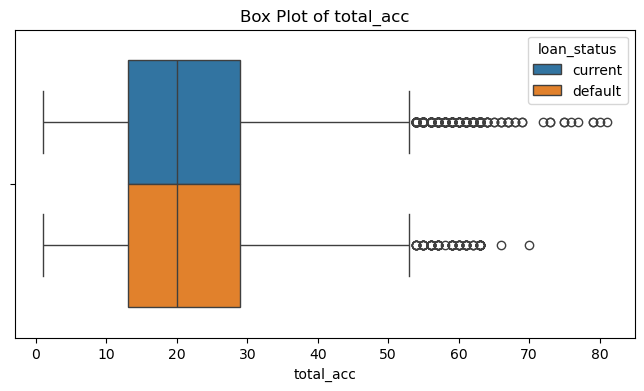

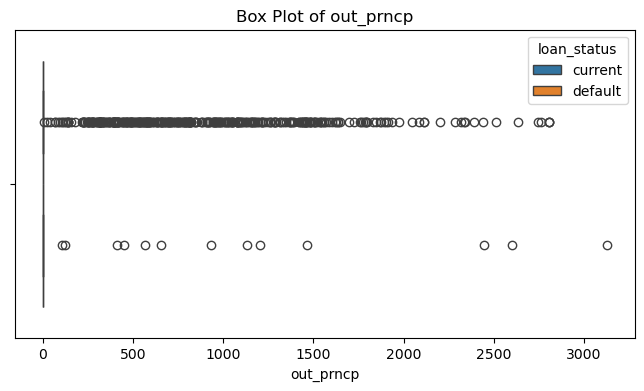

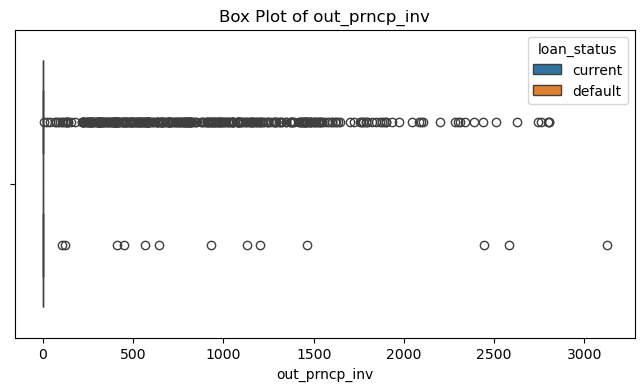

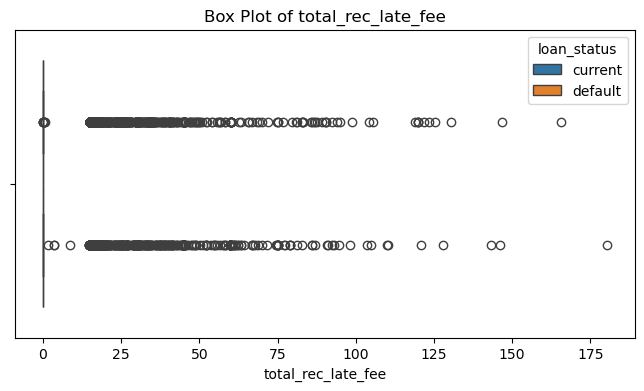

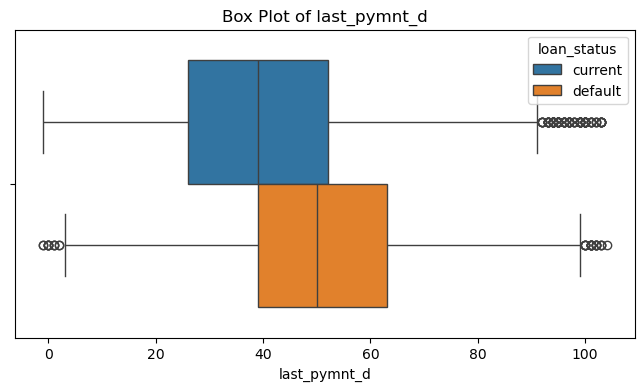

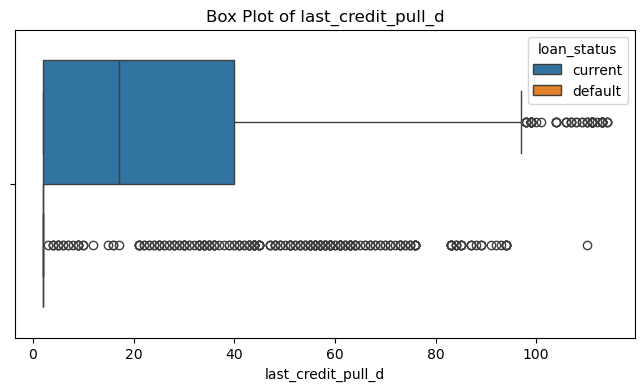

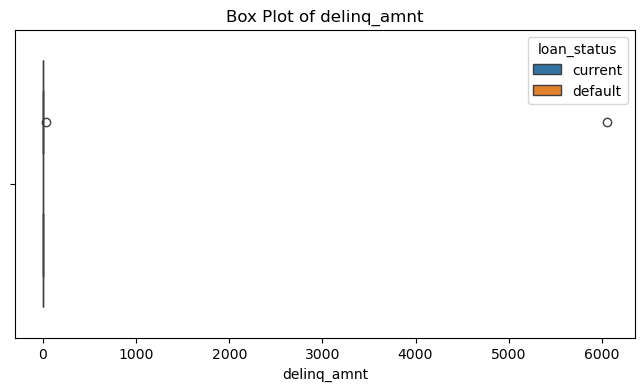

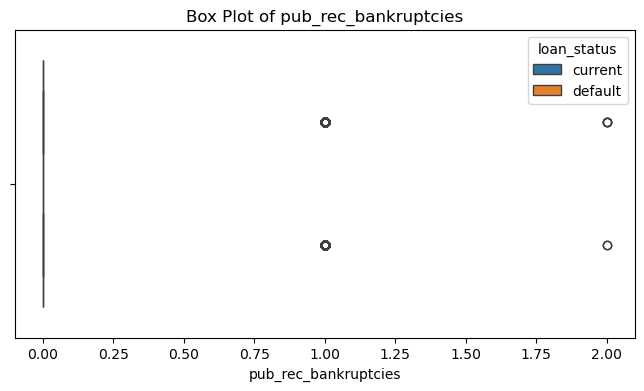

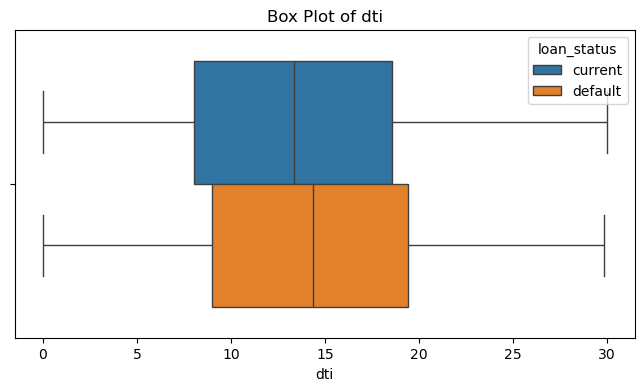

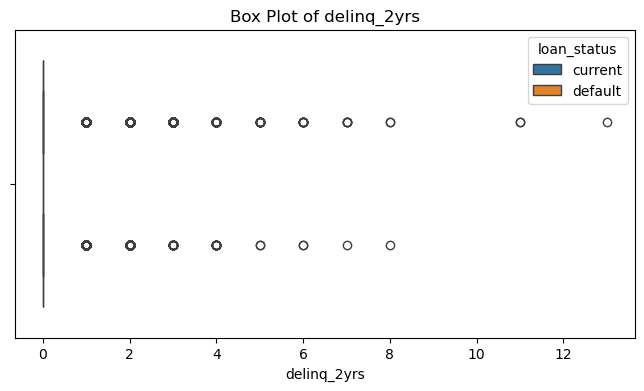

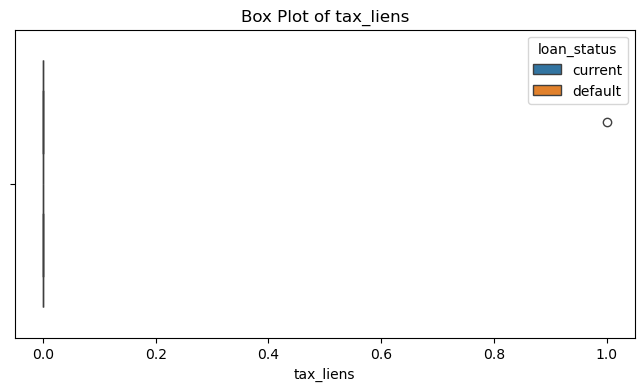

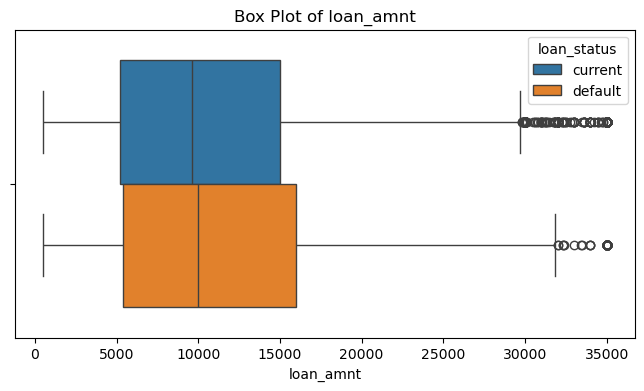

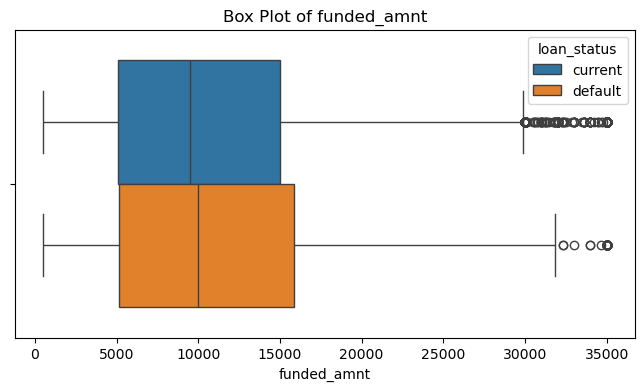

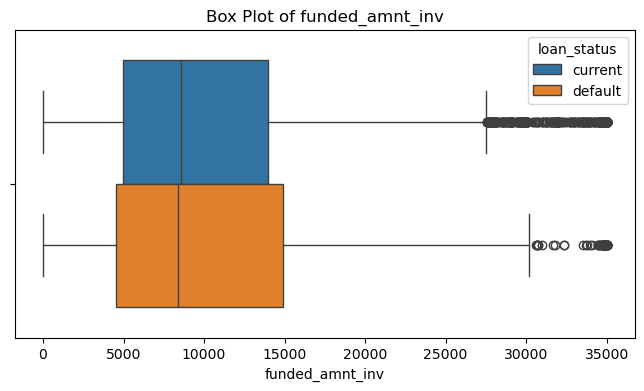

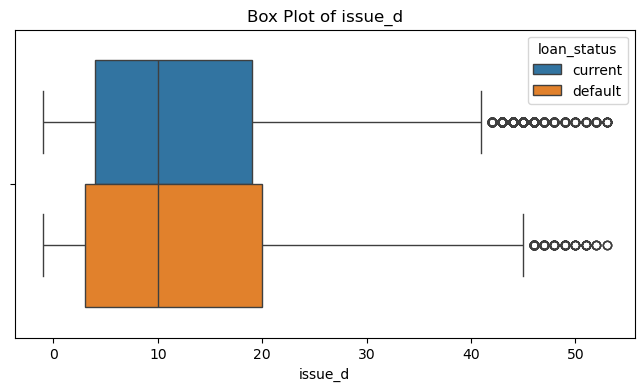

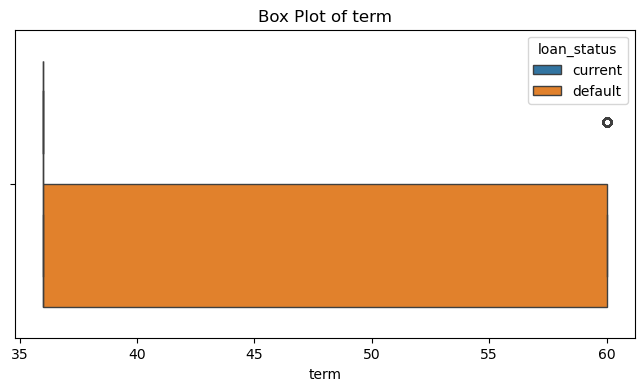

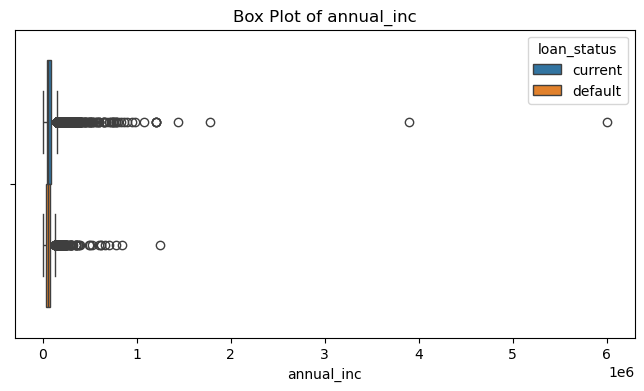

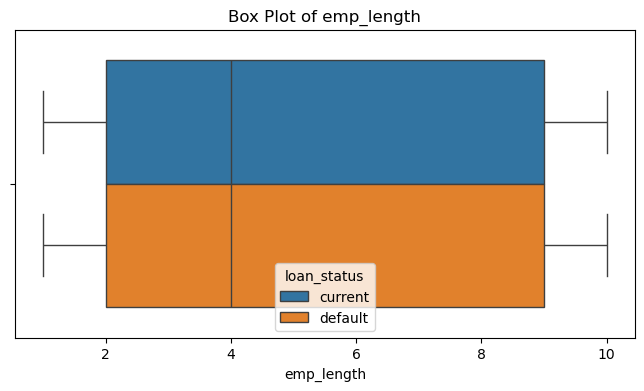

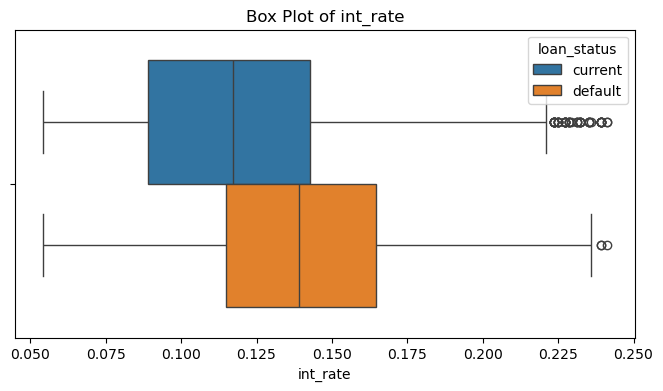

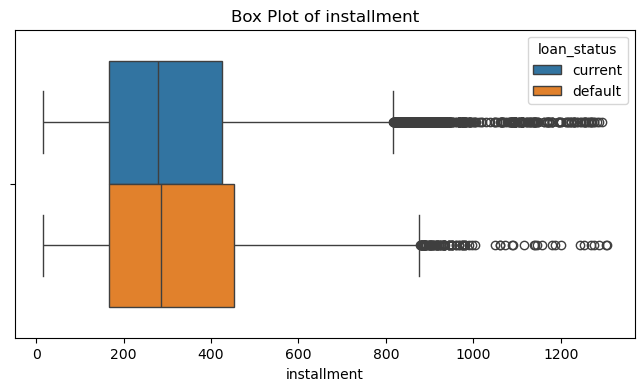

In [19]:
for col in num_cols['feature_name'].to_list():
    plt.figure(figsize=(8, 4))
    sns.boxplot(data= df, x=col, hue="loan_status")
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

### Histograms

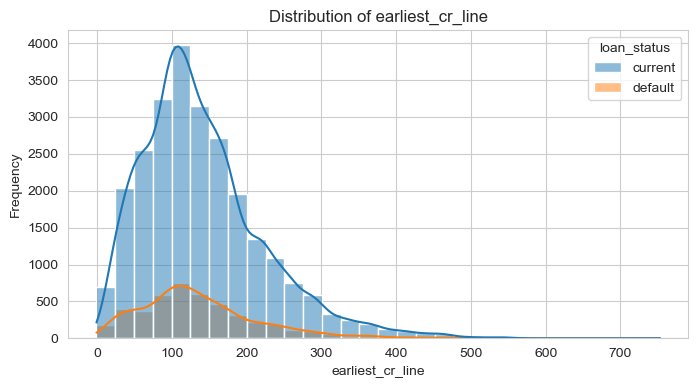

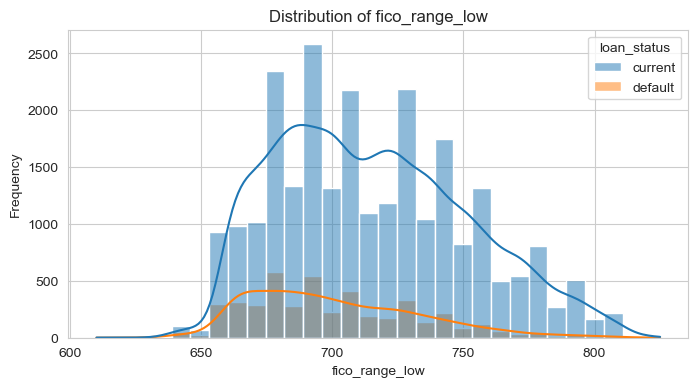

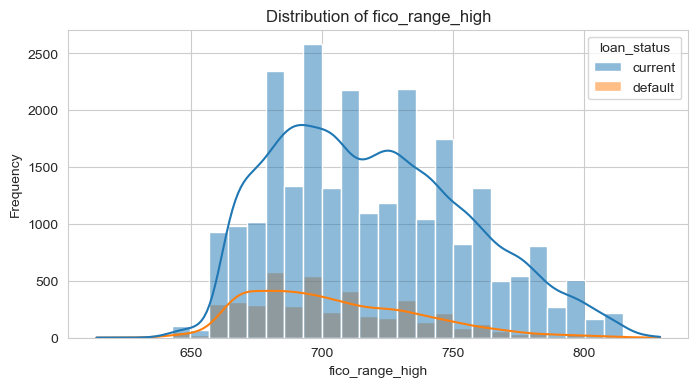

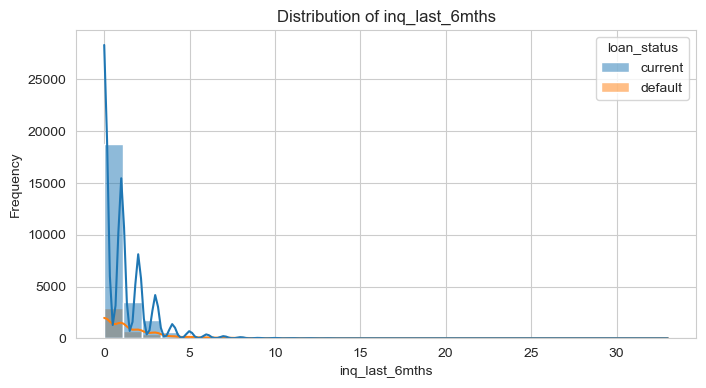

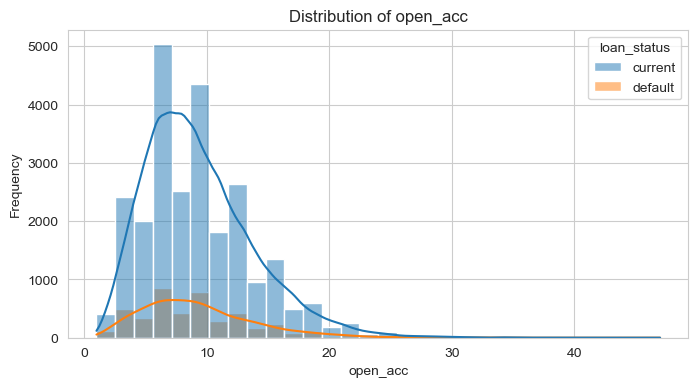

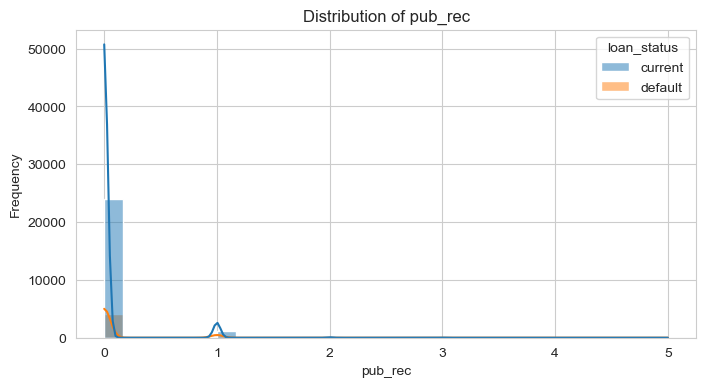

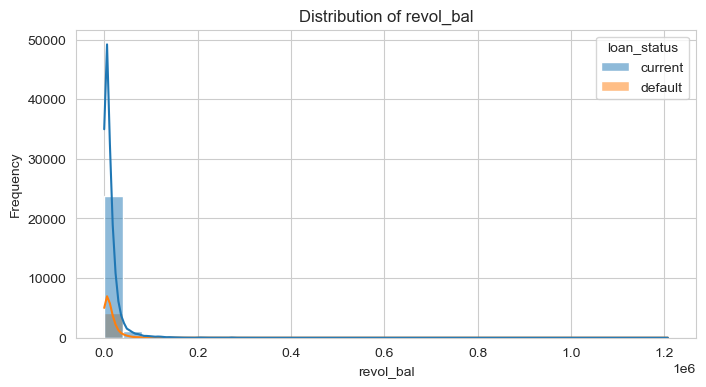

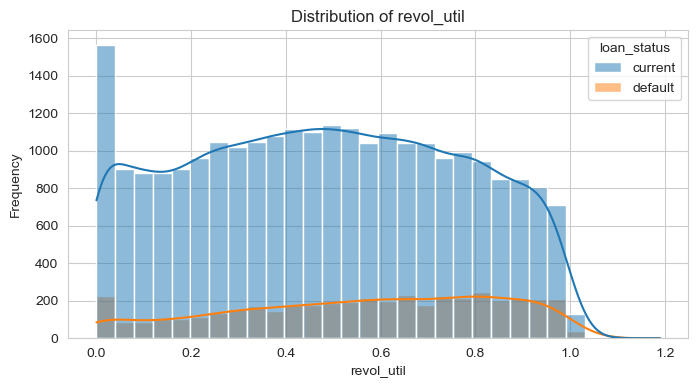

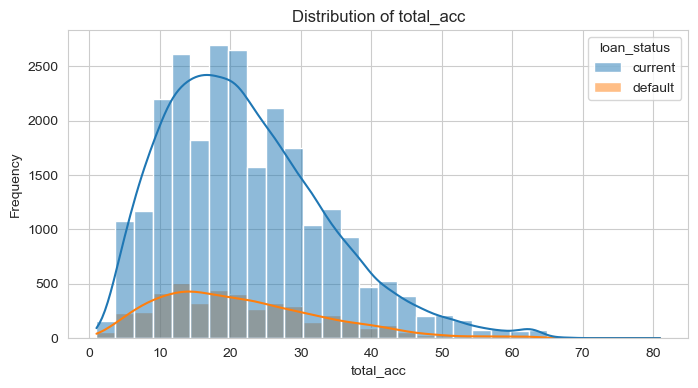

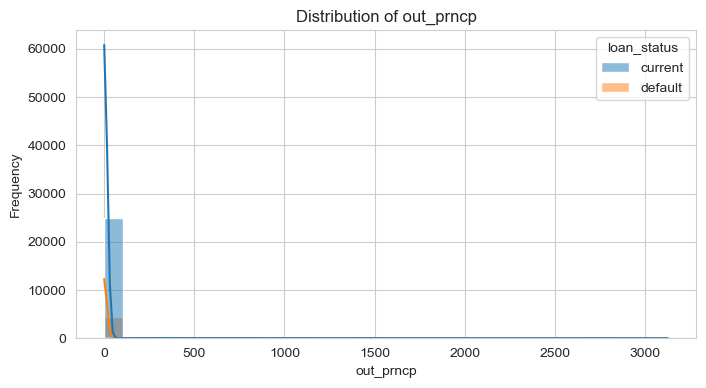

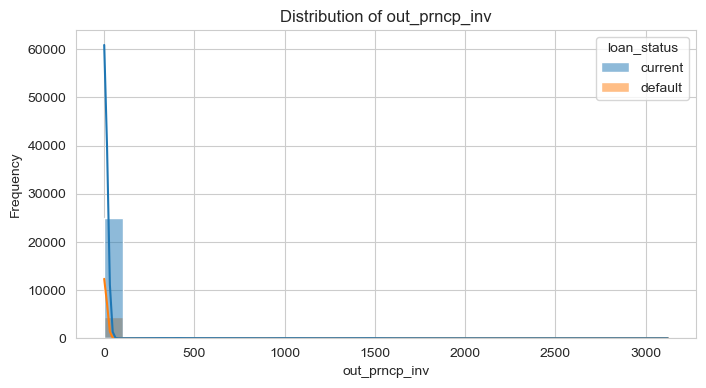

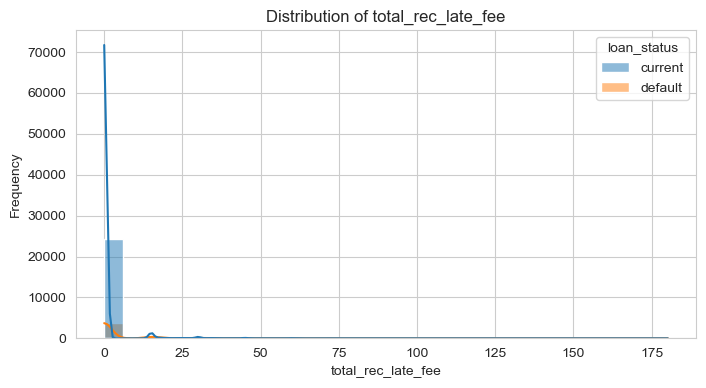

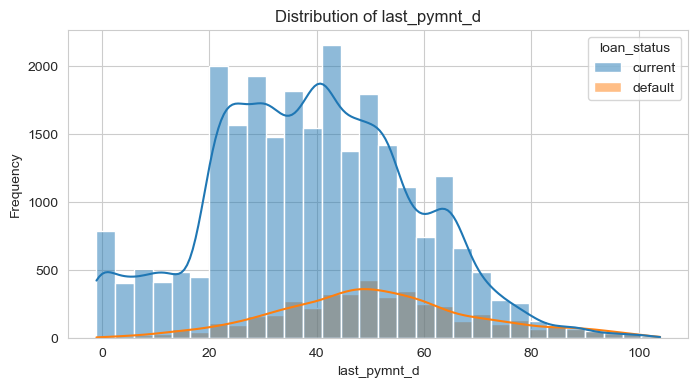

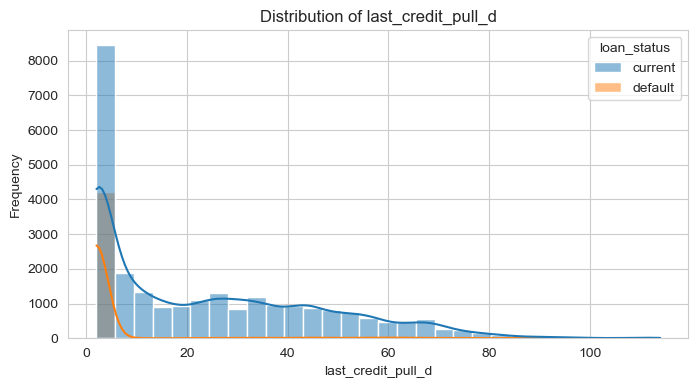

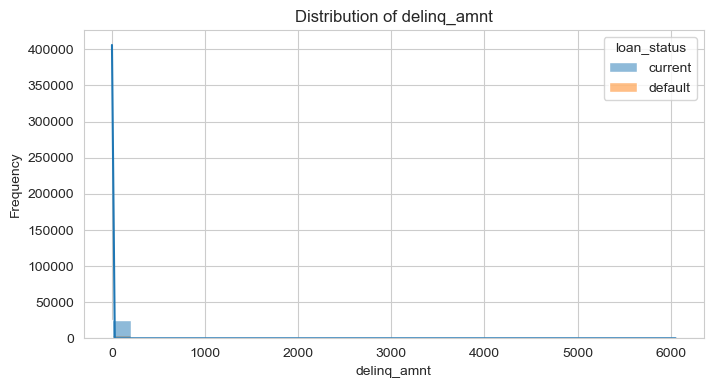

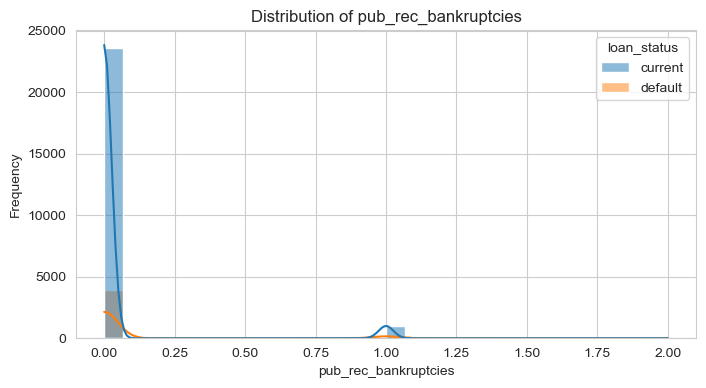

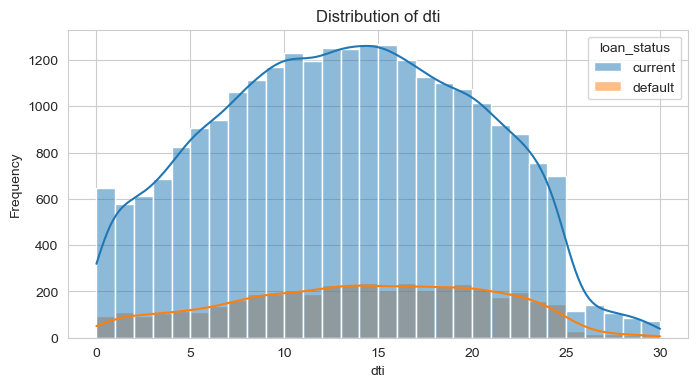

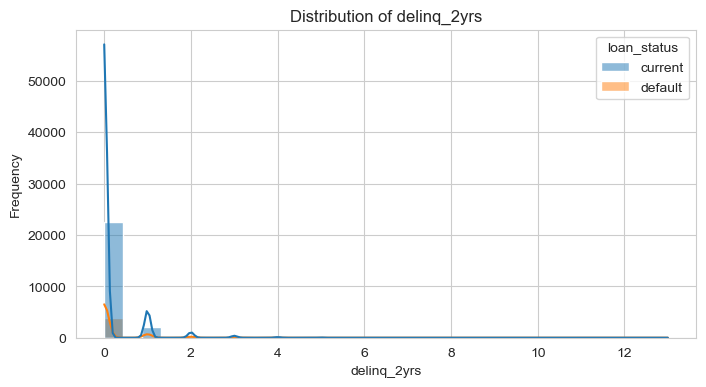

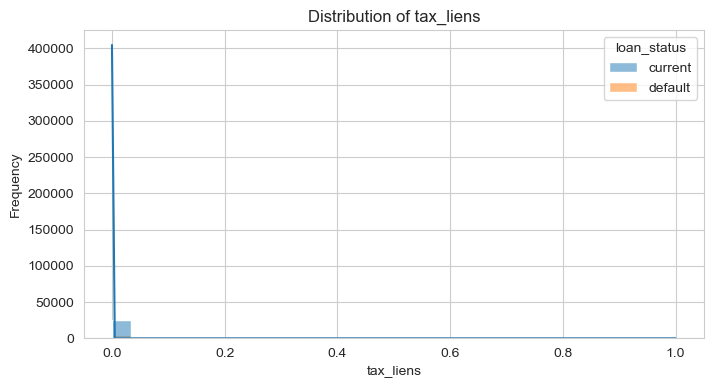

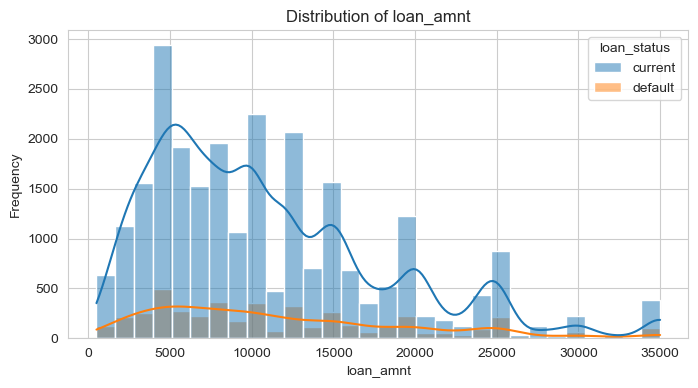

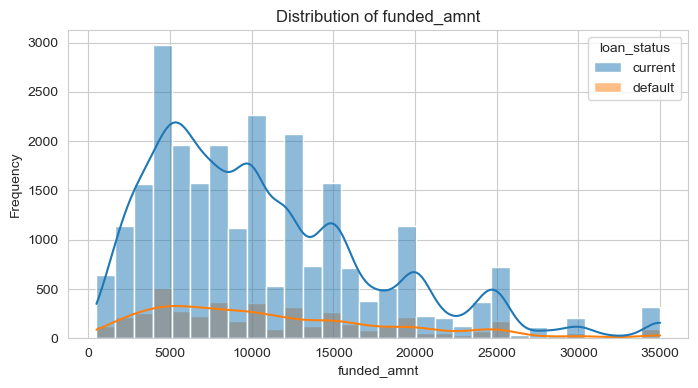

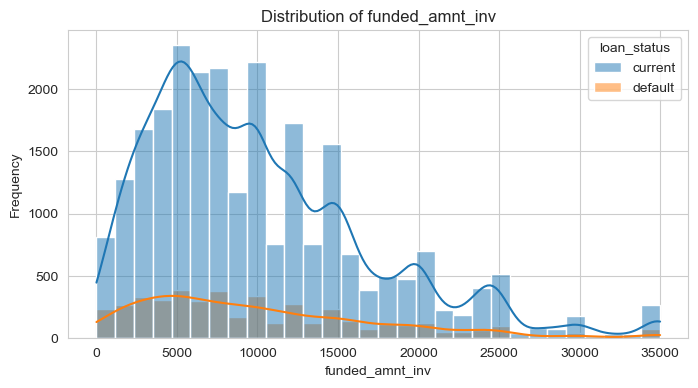

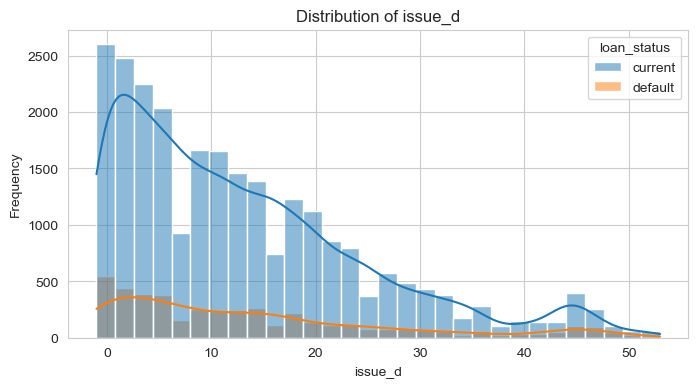

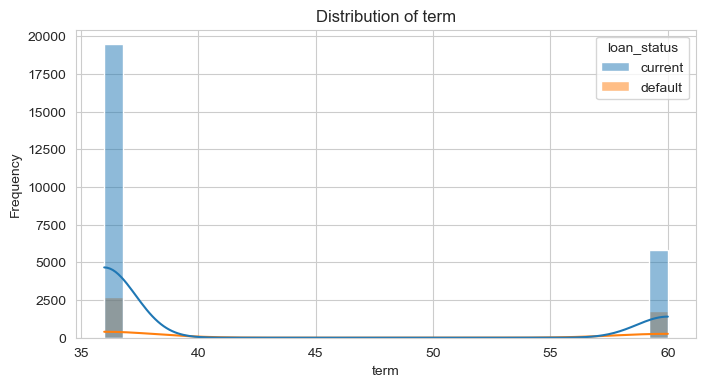

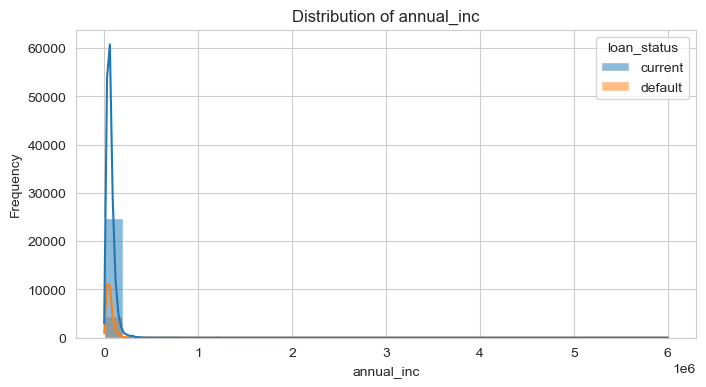

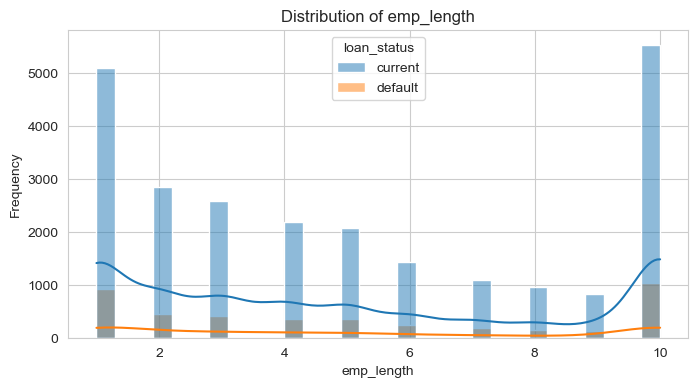

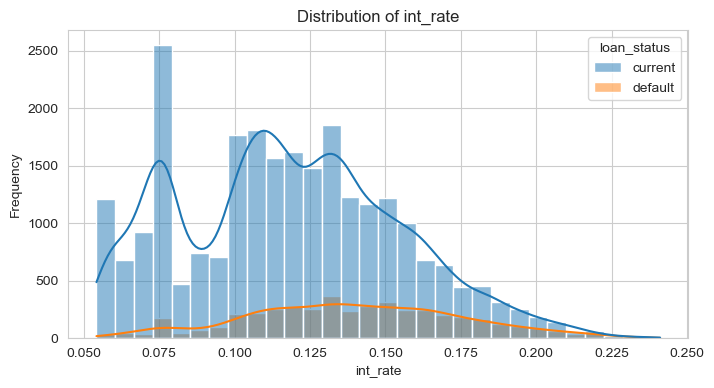

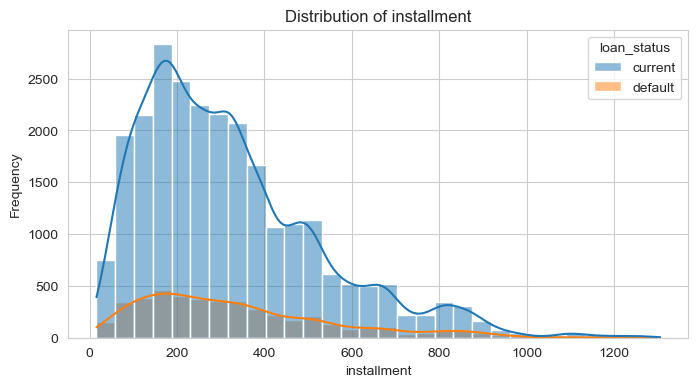

In [20]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for col in num_cols['feature_name'].to_list():
    plt.figure(figsize=(8, 4))
    sns.histplot(data= df, x=col, hue="loan_status", kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### 2-tail KS testing 

This will be used to see if the Defaulting data comes from a different distribution than the current loans.

In [21]:
from scipy.stats import ks_2samp

def ks_results(columns):
  for col in columns:
    dat = df[[col,'loan_status']]
    dat_current = df[df['loan_status']=='current'][col]
    dat_default = df[df['loan_status']=='default'][col]
    print('-----------------------')
    print(col)
    print(ks_2samp(dat_current,dat_default, alternative='two-sided'))

ks_results(num_cols['feature_name'].to_list())

-----------------------
earliest_cr_line
KstestResult(statistic=0.026479299997086536, pvalue=0.00947211242368752, statistic_location=151.0, statistic_sign=-1)
-----------------------
fico_range_low
KstestResult(statistic=0.16545182624234006, pvalue=1.7860519982345262e-91, statistic_location=705.0, statistic_sign=-1)
-----------------------
fico_range_high
KstestResult(statistic=0.16545182624234006, pvalue=1.7860519982345262e-91, statistic_location=709.0, statistic_sign=-1)
-----------------------
inq_last_6mths
KstestResult(statistic=0.10884647133658992, pvalue=1.0527614983800436e-39, statistic_location=0.0, statistic_sign=1)
-----------------------
open_acc
KstestResult(statistic=0.023528372065921455, pvalue=0.02917377236105001, statistic_location=4.0, statistic_sign=-1)
-----------------------
pub_rec
KstestResult(statistic=0.03621475949539188, pvalue=9.039775409445376e-05, statistic_location=0.0, statistic_sign=1)
-----------------------
revol_bal
KstestResult(statistic=0.0226118033

Based on the KS test we can conclude that the following columns provide information that come from two different statistically significant distributions. In the case of the 2 sample KS test H0 is that both datasets come from the same distribution and HA is that they are not. The columns in which we reject fail to reject the null hypothesis at alpha = .05 will not be included in the model because this implies the data is indistinguishable and could cloud the model's predictions. 

In [22]:
num_cols = num_cols['feature_name'].to_list()
num_cols.remove('tax_liens')
num_cols.remove('delinq_amnt')
num_cols.remove('out_prncp')
num_cols.remove('out_prncp_inv')
num_cols.remove('delinq_2yrs')

# Baseline PDP on MLP Regressor

## Create Transformers

In [23]:
# Identify categorical and numerical columns
categorical_cols = cat_cols
numerical_cols = num_cols
feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])



# Define the target variable
y = df['loan_status'].map({'current': 0, 'default': 1})  # Convert to binary
X = df.drop('loan_status', axis=1)


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)

## Fit and Run Model

In [26]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(20,10,), activation='relu', solver='adam', max_iter=500, random_state=42))
])


# Train the model
mlp_pipeline.fit(X_train, y_train)


# Predict and evaluate the model
y_pred = mlp_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Model MSE: {mse:.2f}')
print(f'Model R2: {r2:.2f}')

Model MSE: 0.08
Model R2: 0.35


## Visualize

### Numeric PDP

Computing partial dependence plots...


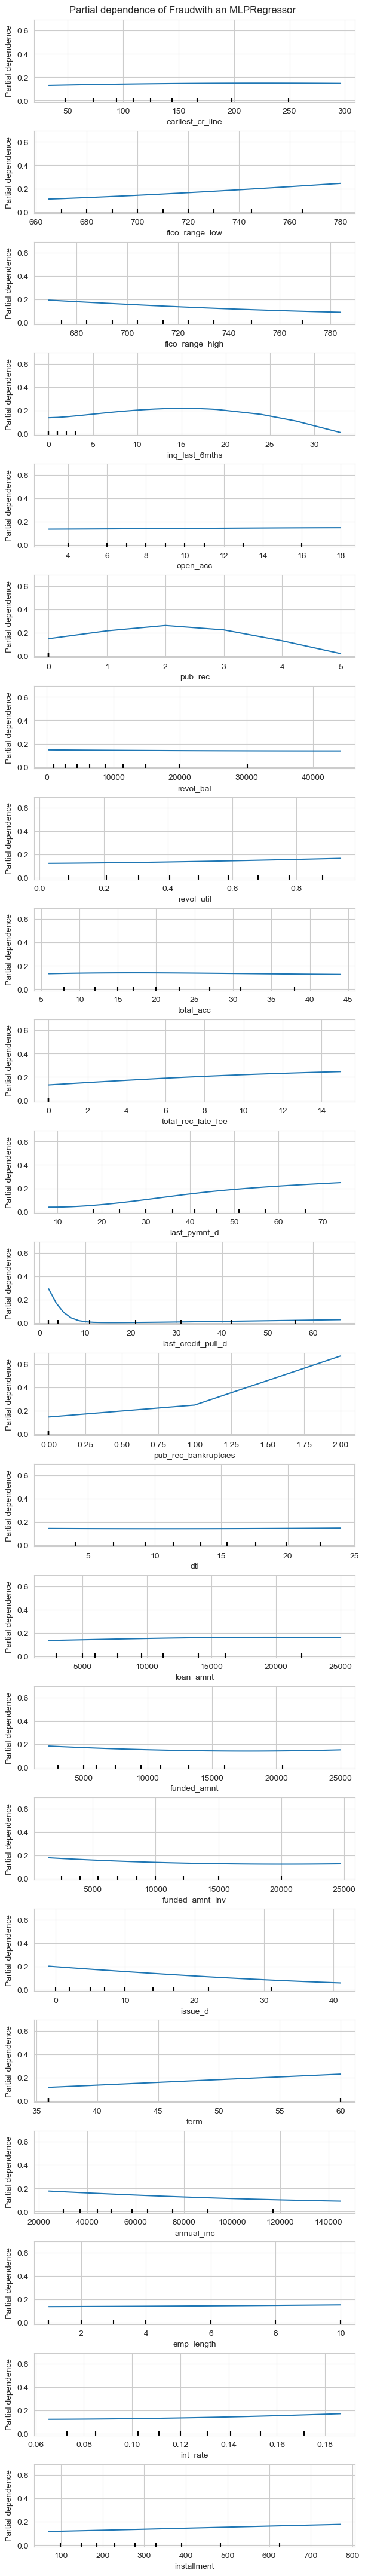

In [27]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 200,
    "n_jobs": -1,
    "grid_resolution": 40,
    "random_state": 0,
}


print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": numerical_cols,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_cols,
}

_, ax = plt.subplots(ncols=1, nrows=23, figsize=(6, 43), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_pipeline,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    (
        "Partial dependence of Fraud"
        "with an MLPRegressor"
    ),
    fontsize=12,
)

From the above graphs we only want to retain columns that do not have a completely flat line. This would mean that the column has no predictive capabilities and would be dead weight when computing the models later.

### Cat PDPs

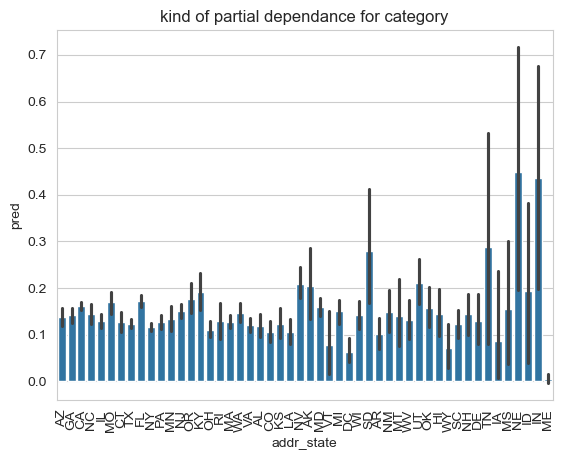

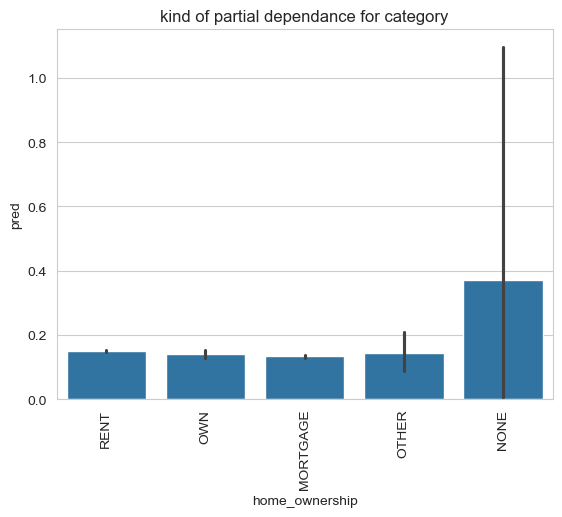

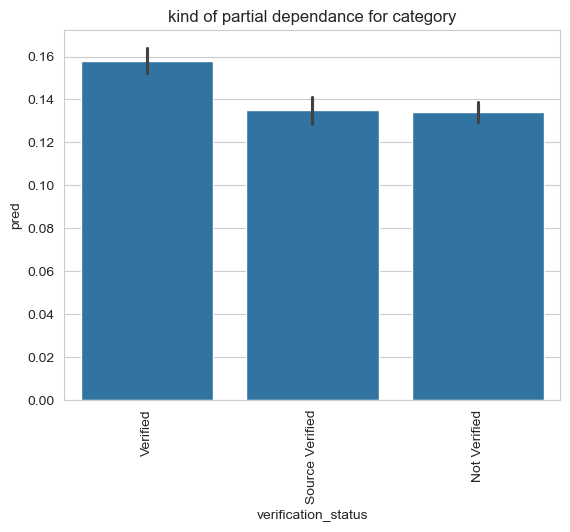

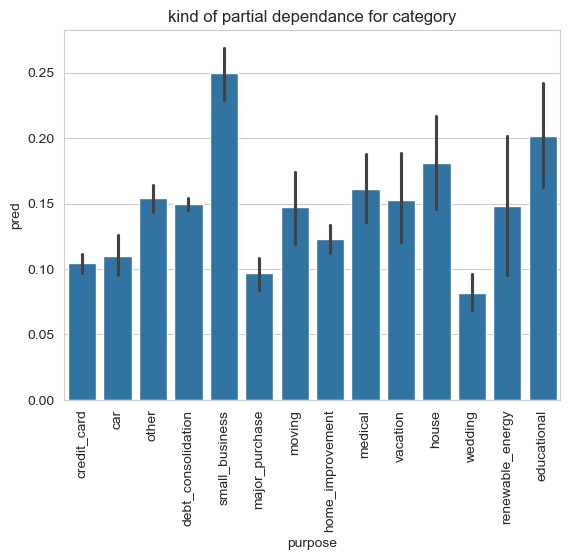

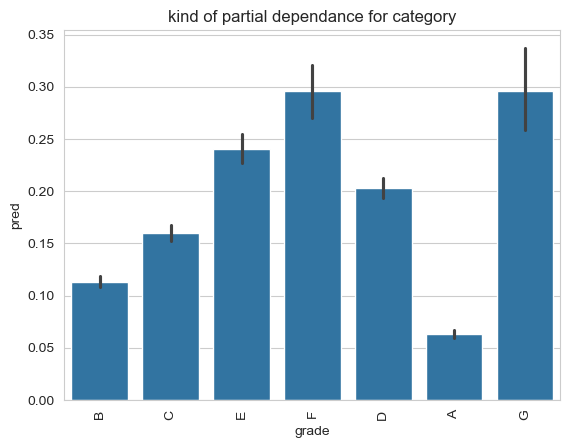

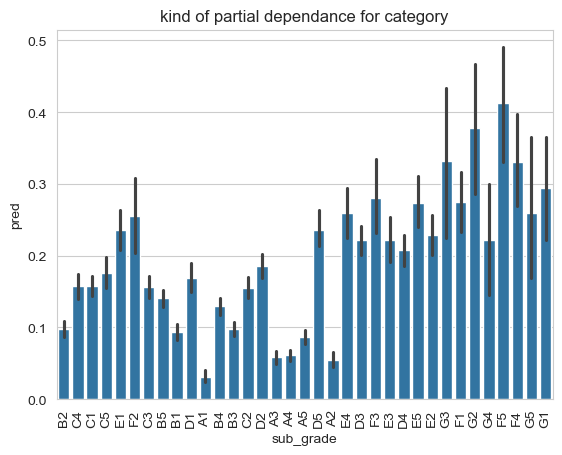

In [28]:
X_s = df[num_cols + cat_cols]
y_s = mlp_pipeline.predict(X)
Z = pd.concat([X_s, pd.Series(y_s, name='pred')], axis=1)

for col in cat_cols:
    sns.barplot(data=Z,x=col,y='pred')
    plt.title("kind of partial dependance for category")
    plt.xticks(rotation = 90)
    plt.show()

Same as with the numeric columns, except we are looking for bars that are all 0 or roughly at the same level implying that we cannot distinguish between the columns or that they have no predictive power.

## Remove variables that are not impactful

In [29]:
rem_list = ['dti', 'revol_bal', 'emp_length', 'revol_util']
for val in rem_list:
    num_cols.remove(val)

# Model Creation

I will create multiple baseline models:

A Logistic Regression for a baseline

A Random Forest for bagging

A XGBoost to search boosting

A MLP to test a Neural Network's efficiency 

After that I will look for a tuned RF, XGB, and MLP

Finally I will be taking my best RF, XGB, and MLP and putting them into a stacking classifier, with the final estimator being a logistic regression.

## Create Transformers

 Since we removed more columns we need to redefine the transformers.

In [30]:
# Identify categorical and numerical columns
categorical_cols = cat_cols
numerical_cols = num_cols
feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])



# Define the target variable
y = df['loan_status'].map({'current': 0, 'default': 1})  # Convert to binary
X = df.drop('loan_status', axis=1)


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)

## Define Baseline Models and Fit

Random-states were defined to ensure reproducability of the model, as well as defining some baseline values.

In [31]:

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier',RandomForestClassifier(random_state=42, n_estimators=100, n_jobs = -1))
])
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier',XGBClassifier(learning_rate=0.1, n_estimators=100, objective = 'binary:logistic', n_jobs = -1, random_state = 42))
])
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(64,32,16,), random_state=42))
])

lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)
mlp_pipeline.fit(X_train, y_train)

print("training complete")

training complete


## Define Searched models and fit

We use a Gridsearch in this scenarion to exhaustivly find the best model from the parameters given. Because the parameter list is not too large this is sufficient, if I were to grow the grids I would need to expand to random search. We chose the models to cross validate three times and be scored based on the best AUC.

In [32]:
param_grid_xgb = {
    'classifier__learning_rate' : [.01, .05, .1, .2],
    'classifier__n_estimators' : [100,250,500],
    'classifier__gamma' : [0,.1,.5]
}
search_xgb = GridSearchCV(xgb_pipeline,param_grid_xgb, cv = 3, scoring='roc_auc')
search_xgb.fit(X_train,y_train)

param_grid_rf = {
    'classifier__n_estimators' : [50,100,500],
    'classifier__max_depth' : [5,10,None],
    'classifier__min_samples_split' : [2,5]
}

search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv = 3, scoring='roc_auc')
search_rf.fit(X_train,y_train)

param_grid_mlp = {
    'classifier__alpha' : [.0001, .001,.01],
    'classifier__learning_rate_init' : [.001, .01, .1]
}

search_mlp = GridSearchCV(mlp_pipeline, param_grid_mlp, cv = 3, scoring = 'roc_auc')
search_mlp.fit(X_train,y_train)

print('training done')

training done


I want to know the best model output from my search so that I can assess them models against each other.

In [33]:
best_rf = search_rf.best_estimator_
print('Best Random Forest')
print(search_rf.best_params_)

print('Best XGB')
best_xgb = search_xgb.best_estimator_
print(search_xgb.best_params_)

print('Best MLP')
print(search_mlp.best_params_)
best_mlp = search_mlp.best_estimator_

Best Random Forest
{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Best XGB
{'classifier__gamma': 0.5, 'classifier__learning_rate': 0.05, 'classifier__n_estimators': 250}
Best MLP
{'classifier__alpha': 0.01, 'classifier__learning_rate_init': 0.1}


## Metrics for models made so far

### Scores

In [57]:
   
def print_variable(variable): # Used to convert variable name into a str for printing
    variable_name = [name for name, value in globals().items() if value is variable][0]
    return variable_name


def table_results(models):
    
    for model in models:
        y_pred= model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluation Metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        model_row = {'Model' : print_variable(model), 
                                  'Accuracy':accuracy, 'AUC':auc, 
                                        'Precision': precision, 'Recall':recall, 'F1' : f1}
        print(model_row)

table_results([lr_pipeline, rf_pipeline, best_rf, xgb_pipeline, best_xgb, mlp_pipeline, best_mlp])

{'Model': 'lr_pipeline', 'Accuracy': 0.8922095366017462, 'AUC': 0.8994765071688359, 'Precision': 0.712707182320442, 'Recall': 0.478486646884273, 'F1': 0.5725699067909454}
{'Model': 'rf_pipeline', 'Accuracy': 0.8981419297067383, 'AUC': 0.9288198586964429, 'Precision': 0.8192419825072886, 'Recall': 0.4169139465875371, 'F1': 0.5526057030481809}
{'Model': 'best_rf', 'Accuracy': 0.9008282963957913, 'AUC': 0.9319093582509088, 'Precision': 0.8328530259365994, 'Recall': 0.4287833827893175, 'F1': 0.5661116552399609}
{'Model': 'xgb_pipeline', 'Accuracy': 0.9107902395343631, 'AUC': 0.9487864084315869, 'Precision': 0.7368873602751504, 'Recall': 0.6357566765578635, 'F1': 0.6825965750696934}
{'Model': 'best_xgb', 'Accuracy': 0.9103425117528543, 'AUC': 0.9494166201835179, 'Precision': 0.7372072853425846, 'Recall': 0.6305637982195845, 'F1': 0.6797281087564975}
{'Model': 'mlp_pipeline', 'Accuracy': 0.879337362883367, 'AUC': 0.8777449831448061, 'Precision': 0.6041666666666666, 'Recall': 0.58086053412462

### Curves

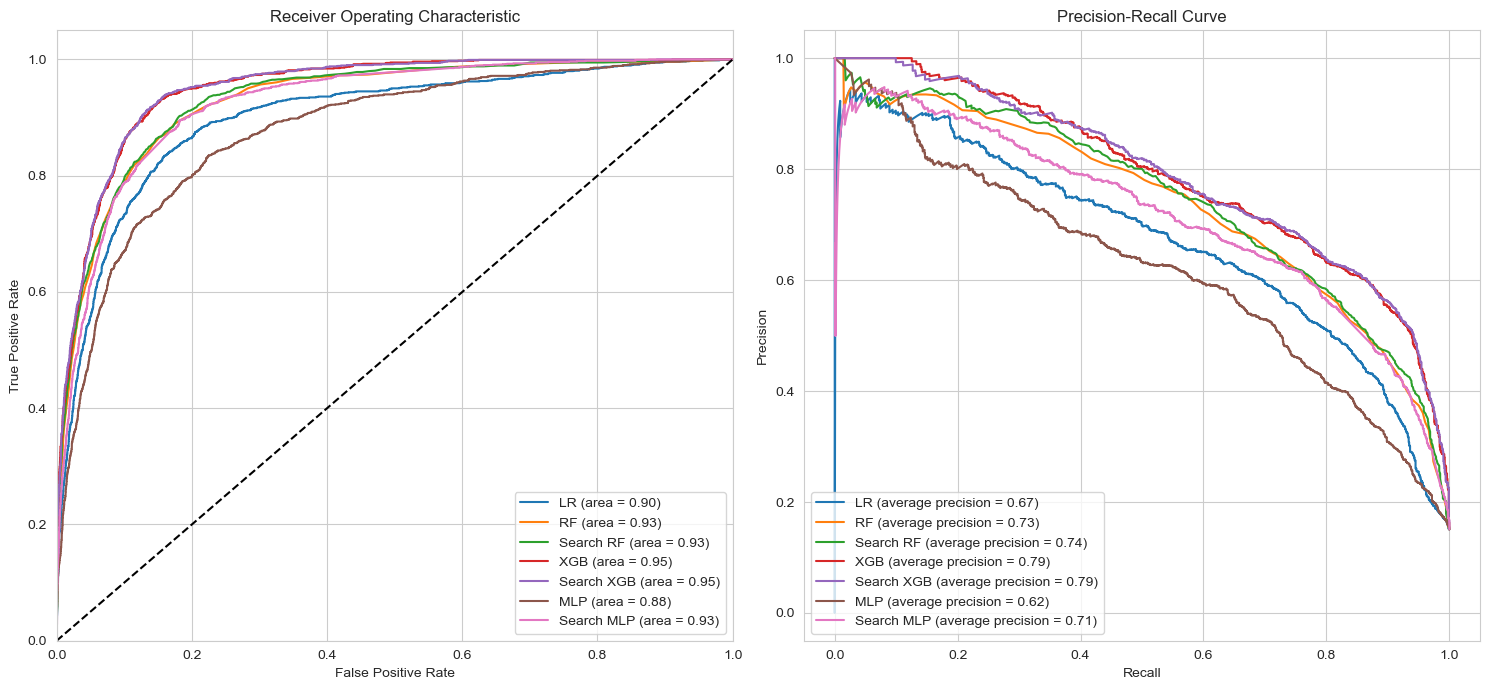

In [35]:
model_set = {"LR": lr_pipeline,
             "RF": rf_pipeline,
             "Search RF" : best_rf,
             "XGB": xgb_pipeline,
             "Search XGB" : best_xgb,
             "MLP" : mlp_pipeline,
             "Search MLP" : best_mlp
             }

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

def plot_model_curves(model_set, X, y):
    plt.figure(figsize=(15, 7))

    # ROC Curve plot
    plt.subplot(1, 2, 1)
    for name, model in model_set.items():
        # Get predicted probabilities
        y_score = model.predict_proba(X_test)[:, 1]
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        # Plot
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # PR Curve plot
    plt.subplot(1, 2, 2)
    for name, model in model_set.items():
        # Get predicted probabilities
        y_score = model.predict_proba(X_test)[:, 1]
        # Compute PR curve and PR area
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        average_precision = average_precision_score(y_test, y_score)
        # Plot
        plt.plot(recall, precision, label=f'{name} (average precision = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

plot_model_curves(model_set, X_test, y_test)

## Stacking Classifier

In [36]:
base_estimators = [
    ('xgb', XGBClassifier(gamma = 0.5, learning_rate =0.05, n_estimators = 250, objective = 'binary:logistic', n_jobs = -1)),
    ('rf', RandomForestClassifier(max_depth= None, min_samples_split = 2, n_estimators = 500, random_state=42,n_jobs = -1)),
    ('nn', MLPClassifier(hidden_layer_sizes=(64,32,16,), random_state=42, alpha = 0.01, learning_rate_init = 0.1))
]

final_estimator = LogisticRegression(random_state=42)


stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1
)

stacking_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_classifier)])

stacking_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['earliest_cr_line',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'total_acc',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_d',
                                                   'last_credit_pull_d',
                                                   'pub_rec_bankruptcies',
                                                   'lo...
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=250,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=500,
                                                                        n_jobs=-1,
                                                                        random_state=42)),
                                                ('nn',
                                                 MLPClassifier(alpha=0.01,
                                                               hidden_layer_sizes=(64,
                                                                                   32,
                                                                                   16),
                                                               learning_rate_init=0.1,
                                                               random_state=42))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1))])

### Evaluation

### Scoring

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Predictions for the training set
y_train_pred = stacking_pipe.predict(X_train)
y_train_prob = stacking_pipe.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = stacking_pipe.predict(X_test)
y_test_prob = stacking_pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.98
Precision (default): 0.98
Recall (default): 0.92
F1 Score (default): 0.95
AUC: 1.00

Test Metrics:
Accuracy: 0.91
Precision (default): 0.75
Recall (default): 0.60
F1 Score (default): 0.66
AUC: 0.94


### Curves

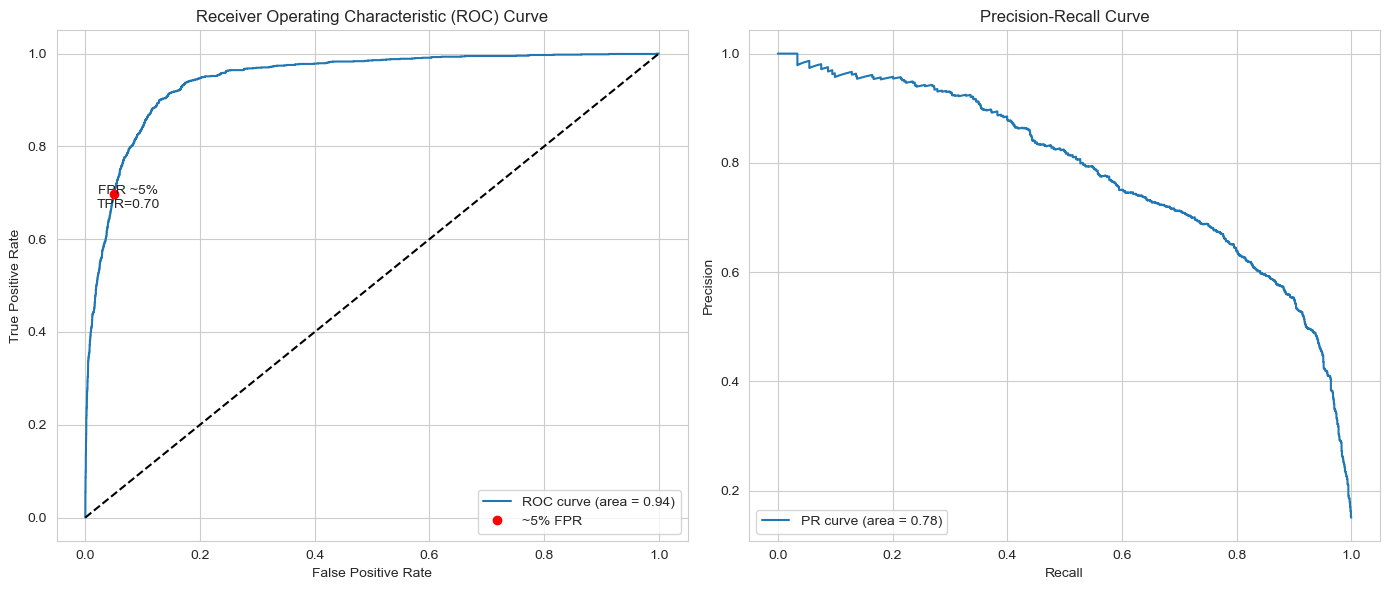

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc


# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# My Best Model

After assessing the scoring and curves of my model I have determined that I will be using the stacking classifier as my best model. Due to the XGBoost and Stacking Classifier being so close in scoring I decided to go with the Stacking Classifier because its PR curve is smoother implying that it is better at general predictions and could thus be used more efficiently on completely new data. This would reduce the bias on the test set of data even further leading to more reliable predictions long term.

In [67]:
# Predict probabilities for the positive class
y_scores = stacking_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
# Define target FPR values
target_fpr = np.arange(0.01, 0.06, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds_roc)    

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.40134,0.77386
1,2.00000,0.50223,0.66508
2,3.00000,0.57789,0.54762
3,4.00000,0.63576,0.44670
4,5.00000,0.69659,0.35184


# Explain my Best Model

In [39]:
#%pip install dalex

In [40]:
import dalex as dx

I am creating an instance of Dalex Explainer to access variable importance, PDP, breakdown, and shapley values for my best model

In [41]:
pipeline_explainer = dx.Explainer(stacking_pipe, X_test, y_test)
pipeline_explainer

Preparation of a new explainer is initiated

  -> data              : 8934 rows 25 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8934 values
  -> model_class       : sklearn.ensemble._stacking.StackingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000189BB83D000> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0201, mean = 0.147, max = 0.979
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.966, mean = 0.00344, max = 0.98
  -> model_info        : package sklearn

A new explainer has been created!


## Variable Importance

In [42]:
# Calculate feature importance
fi = pipeline_explainer.model_parts(processes=4)

# Plot feature importance
fi.plot()

From the bar chart above we can infer that columns last_credit_pull_d, last_pymnt_d, issue_d, and term are the most important columns to determine if a loan will default or not in my stacking classifier model.

## PDP Numeric

In [43]:
# Let's say you want to create PDPs for a feature named 'feature_name'
pdp_numeric_profile = pipeline_explainer.model_profile(variables=numerical_cols)

# Now, plot the PDP for 'feature_name'
pdp_numeric_profile.plot()

Calculating ceteris paribus: 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


Although some columns showed importance when passed through the MLP Regressor we can see that when it came down to the specific model I used there were only a few that played a large role in the final predictions. Those were annual_inc, int_rate, issue_d, term, last_credit_pull_d, last_pymnt_d, and total_rec_late_fee.

## PDP Categorical

In [44]:
pdp_categorical_profile = pipeline_explainer.model_profile(
    variable_type = 'categorical',
    variables=categorical_cols)

# Now, plot the PDP for 'feature_name'
pdp_categorical_profile.plot()

Calculating ceteris paribus: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


Some columns categorical variables ended up not having much impact. However, the state they lived in and purpose had major impact, with grade and subgrade,interestingly enough not deviating mych from its intercept

# Ten best TP by % probability

In [45]:
X_test['pred']= stacking_pipe.predict(X_test)
X_test['pred_proba']= stacking_pipe.predict_proba(X_test)[:, 1]
X_test['loan_status'] = y_test
X_test.head()

top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp

,addr_state,home_ownership,verification_status,purpose,grade,sub_grade,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,...,funded_amnt,funded_amnt_inv,issue_d,term,annual_inc,int_rate,installment,pred,pred_proba,loan_status
0,TX,RENT,Not Verified,other,D,D5,26.00000,705.00000,709.00000,3.00000,...,2400.00000,2400.00000,17.00000,60.00000,20800.00000,0.16320,58.78000,1,0.97878,1
1,CA,MORTGAGE,Not Verified,other,D,D3,161.00000,705.00000,709.00000,3.00000,...,7850.00000,3799.99931,43.00000,36.00000,200000.00000,0.13240,265.41000,1,0.97749,1
2,CA,RENT,Source Verified,car,D,D4,74.00000,685.00000,689.00000,0.00000,...,4000.00000,3975.00000,13.00000,60.00000,26400.00000,0.15950,97.17000,1,0.97736,1
3,IN,MORTGAGE,Not Verified,major_purchase,E,E4,78.00000,645.00000,649.00000,20.00000,...,7200.00000,1849.99341,47.00000,36.00000,53000.00000,0.14380,247.41000,1,0.97724,1
4,CA,MORTGAGE,Source Verified,small_business,E,E3,306.00000,680.00000,684.00000,6.00000,...,12000.00000,10700.00000,13.00000,60.00000,60000.00000,0.17190,299.46000,1,0.97722,1
5,FL,RENT,Not Verified,small_business,G,G3,37.00000,640.00000,644.00000,4.00000,...,8550.00000,1174.99527,49.00000,36.00000,60000.00000,0.17220,305.77000,1,0.97708,1
6,GA,RENT,Not Verified,other,D,D5,71.00000,685.00000,689.00000,0.00000,...,5000.00000,4925.00000,23.00000,36.00000,51200.00000,0.16000,175.79000,1,0.97510,1
7,CA,MORTGAGE,Verified,debt_consolidation,E,E5,373.00000,670.00000,674.00000,0.00000,...,13225.00000,13200.00000,3.00000,60.00000,40000.00000,0.19690,348.11000,1,0.97475,1
8,PA,RENT,Source Verified,other,D,D3,96.00000,695.00000,699.00000,4.00000,...,10000.00000,8700.00000,14.00000,60.00000,55000.00000,0.15580,240.96000,1,0.97451,1
9,NJ,RENT,Source Verified,debt_consolidation,E,E4,24.00000,675.00000,679.00000,2.00000,...,8000.00000,7975.00000,8.00000,60.00000,40000.00000,0.17510,201.03000,1,0.97441,1


## Break Down

Breakdown is a method used to unveil what is inside the black box of a model, telling us the breakdown of probabilities that each column value gives to the final prediction.

In [46]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()


## Shap Values

We will use Shapley values to infer the proabablistic impact of each column in the data. These are computationally expensive but are model agnostic and good for general understanding of impact.

In [47]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Ten worst FN by % probability

In [49]:
top_10_fn = (X_test
             .query('loan_status != pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=True)
             .head(10)
             .reset_index(drop=True)
)
top_10_fn

,addr_state,home_ownership,verification_status,purpose,grade,sub_grade,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,...,funded_amnt,funded_amnt_inv,issue_d,term,annual_inc,int_rate,installment,pred,pred_proba,loan_status
0,NV,OWN,Verified,major_purchase,A,A4,145.00000,780.00000,784.00000,0.00000,...,10000.00000,9950.00000,6.00000,36.00000,59000.00000,0.07490,311.02000,0,0.02019,1
1,FL,MORTGAGE,Not Verified,home_improvement,A,A1,298.00000,775.00000,779.00000,1.00000,...,5000.00000,5000.00000,6.00000,36.00000,50000.00000,0.05420,150.80000,0,0.02101,1
2,NJ,MORTGAGE,Verified,debt_consolidation,A,A3,404.00000,780.00000,784.00000,0.00000,...,23000.00000,23000.00000,10.00000,36.00000,98000.00000,0.06170,701.48000,0,0.02134,1
3,FL,MORTGAGE,Not Verified,home_improvement,A,A3,82.00000,765.00000,769.00000,1.00000,...,5000.00000,4950.00000,14.00000,36.00000,54000.00000,0.07140,154.71000,0,0.02168,1
4,GA,MORTGAGE,Not Verified,home_improvement,C,C2,113.00000,690.00000,694.00000,2.00000,...,5000.00000,5000.00000,24.00000,36.00000,110000.00000,0.13220,169.01000,0,0.02196,1
5,CA,OWN,Verified,debt_consolidation,D,D4,141.00000,670.00000,674.00000,0.00000,...,15850.00000,15844.21206,26.00000,36.00000,55000.00000,0.15650,554.53000,0,0.02198,1
6,NY,MORTGAGE,Not Verified,credit_card,B,B4,140.00000,680.00000,684.00000,0.00000,...,7500.00000,7250.00000,5.00000,36.00000,45500.00000,0.11490,247.29000,0,0.02212,1
7,AZ,RENT,Not Verified,debt_consolidation,D,D1,93.00000,665.00000,669.00000,0.00000,...,12000.00000,12000.00000,11.00000,36.00000,42000.00000,0.14090,410.66000,0,0.02285,1
8,CA,MORTGAGE,Source Verified,major_purchase,C,C2,113.00000,670.00000,674.00000,0.00000,...,7500.00000,7500.00000,7.00000,36.00000,110656.00000,0.13060,252.93000,0,0.02291,1
9,NC,MORTGAGE,Source Verified,debt_consolidation,B,B2,107.00000,720.00000,724.00000,1.00000,...,7000.00000,6975.00000,4.00000,36.00000,110000.00000,0.10590,227.82000,0,0.02329,1


## Shap Values

In [50]:
for index, row in top_10_fn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fn.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Top 10 TN by % Probability

In [60]:
top_10_tn = (X_test
             .query('loan_status == pred and loan_status == 0')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tn

,addr_state,home_ownership,verification_status,purpose,grade,sub_grade,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,...,funded_amnt,funded_amnt_inv,issue_d,term,annual_inc,int_rate,installment,pred,pred_proba,loan_status
0,FL,MORTGAGE,Verified,debt_consolidation,E,E3,188.00000,660.00000,664.00000,5.00000,...,15000.00000,14747.55365,25.00000,36.00000,90000.00000,0.17040,535.12000,0,0.49995,0
1,MD,MORTGAGE,Source Verified,debt_consolidation,C,C1,94.00000,665.00000,669.00000,0.00000,...,6000.00000,6000.00000,-1.00000,36.00000,60000.00000,0.13490,203.59000,0,0.49656,0
2,CA,RENT,Not Verified,debt_consolidation,C,C1,166.00000,765.00000,769.00000,0.00000,...,17600.00000,17350.00000,3.00000,60.00000,43000.00000,0.12990,400.37000,0,0.49412,0
3,PA,MORTGAGE,Verified,debt_consolidation,D,D5,231.00000,705.00000,709.00000,1.00000,...,28800.00000,28616.15829,2.00000,60.00000,175000.00000,0.18250,735.26000,0,0.49297,0
4,CA,RENT,Not Verified,debt_consolidation,A,A4,210.00000,725.00000,729.00000,0.00000,...,7900.00000,7900.00000,8.00000,36.00000,36572.88000,0.07290,244.98000,0,0.49245,0
5,NY,RENT,Source Verified,vacation,B,B5,84.00000,685.00000,689.00000,1.00000,...,4000.00000,4000.00000,5.00000,36.00000,36000.00000,0.11990,132.84000,0,0.49197,0
6,AZ,RENT,Not Verified,debt_consolidation,B,B4,116.00000,765.00000,769.00000,1.00000,...,10500.00000,10500.00000,6.00000,60.00000,35364.00000,0.11490,230.87000,0,0.49195,0
7,NY,MORTGAGE,Source Verified,debt_consolidation,C,C4,294.00000,690.00000,694.00000,1.00000,...,12000.00000,2425.00000,34.00000,36.00000,315000.00000,0.13470,407.08000,0,0.48883,0
8,CA,MORTGAGE,Source Verified,home_improvement,A,A5,16.00000,735.00000,739.00000,0.00000,...,6000.00000,6000.00000,6.00000,36.00000,35000.00000,0.08490,189.38000,0,0.48713,0
9,MD,MORTGAGE,Verified,debt_consolidation,C,C3,100.00000,680.00000,684.00000,3.00000,...,10625.00000,10600.00000,4.00000,36.00000,60785.00000,0.13990,363.09000,0,0.48698,0


In [61]:
for index, row in top_10_tn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tn.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Predict on Holdout

This cell applies the transformations done to the origional data so that we can predict over it on the holdout data.

In [56]:
path = "C:/Users/bryce/Downloads/loan_holdout.csv"
holdout = pd.read_csv(path)

type_change_list = ['acc_now_delinq']
for col in type_change_list:
    df[col] = df[col].mask(lambda x: x.notna(), df[col].astype(str))

holdout['revol_util'] = holdout['revol_util'].str.strip('%')
holdout['int_rate'] = holdout['int_rate'].str.strip('%')
holdout['revol_util'] = holdout['revol_util'].astype('float')/100
holdout['int_rate'] = holdout['int_rate'].astype('float')/100
holdout['term'] = pd.to_numeric(holdout['term'].str.replace(' months',''))
emp_rem = [' year', 's','+', '< ']
for string in emp_rem:
    holdout['emp_length'] = holdout['emp_length'].str.replace(string ,'')
holdout['emp_length']=holdout['emp_length'].astype('float')


holdout['earliest_cr_line'] = pd.to_datetime(holdout['earliest_cr_line'])
holdout['issue_d'] = pd.to_datetime(holdout['issue_d'])
holdout['last_credit_pull_d'] = pd.to_datetime(holdout['last_credit_pull_d'])
holdout['last_pymnt_d'] = pd.to_datetime(holdout['last_pymnt_d'])


holdout['earliest_cr_line'] = 12*(max_earliest.year - holdout.earliest_cr_line.dt.year) + (max_earliest.month - holdout.earliest_cr_line.dt.month) - 1
holdout['issue_d'] = 12 * (max_issue.year - holdout.issue_d.dt.year) + (max_issue.month - holdout.issue_d.dt.month) - 1
holdout['last_credit_pull_d'] = 12* (max_credit.year - holdout.last_credit_pull_d.dt.year) + (max_issue.month - holdout.last_credit_pull_d.dt.month) - 1
holdout['last_pymnt_d'] = 12 * (max_pymnt.year - holdout.last_pymnt_d.dt.year) + (max_pymnt.month - holdout.last_pymnt_d.dt.month) - 1



holdout['pred_proba']= stacking_pipe.predict_proba(holdout)[:, 1]
holdout['pred']= stacking_pipe.predict(holdout)

outpath  = 'C:/Users/bryce/Downloads/loan_holdout_w_preds.csv'
holdout.to_csv(outpath)